### Homework02 - Unsupervised Deep Learning

student name : Daniele Mellino <br>
student id : 2013373<br>
Course: Neural Network and Deep Learning <br>
Professor: Testolin Alberto<br>

* Implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and 
some examples of image reconstruction; explore advanced optimizers and regularization methods 

* optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna) 

* fine-tune the (convolutional) autoencoder using a supervised classification task, and compare 
classification accuracy and learning speed with results achieved in Homework 1

* explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes 

*  implement and test variational (convolutional) autoencoder or GAN or SimCLR 

# Libraries 



In [ ]:
!pip install optuna mlflow
! pip install plotly
!pip install pyyaml==5.4.1

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 15.6 MB 41.6 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 210 kB 46.0 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 180 kB 29.9 MB/s 
     |████████████████████████████████| 146 kB 47.9 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 149 kB 47.8 MB/s 
     |████████████████████████████████| 113 kB 48.4 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=c66e64399751b76dcf08b6781a8796d1640a0e030

In [ ]:
#libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import optuna , mlflow
import copy
import sklearn

from tqdm.notebook import tqdm # this module is useful to plot progress bars
import pathlib
import plotly
import imageio
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn

import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

# Dataset(FashionMNIST)

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)

# Data normalization
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.

train_mean = train_dataset.data.float().mean() / 255.
train_std = train_dataset.data.float().std() / 255.

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean:.4f}")
print(f"Standard Deviation: {train_std:.4f}")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

-----  TRAIN NORMALIZATION VALUES  -----
Mean: 0.2860
Standard Deviation: 0.3530


In [ ]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

train_dataset.transform = train_transforms
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=test_transforms)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [ ]:
#create validation set 20% of all the data
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                         [48000, 12000])
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(val_dataloader))
print(f"VAL BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
VAL BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# First Convolutional autoencoder

### early stopping class

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

### the model

In [ ]:
class ConvAutoE(nn.Module):
    def __init__(self,neur_encoding = 2, n_feature = 4) :
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      # --> img size = = 14x14
                                      nn.Conv2d(1, n_feature, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Second convolutional layer
                                      # --> img size = 7x7 
                                      nn.Conv2d(n_feature, 2*n_feature, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Third convolutional layer
                                      # --> img size =  3x3
                                      nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=3, padding=0, stride=2),
                                      nn.ReLU(),
                                      # Flatten layer
                                      nn.Flatten(start_dim=1),
                                      # First linear layer
                                      nn.Linear(36*n_feature, 64), # arbitrary number of output units
                                      nn.ReLU(),
                                      # Second linear layer (output layer)
                                      nn.Linear(64, neur_encoding)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( # First linear layer
                                       nn.Linear(neur_encoding, 64), 
                                       nn.ReLU(True),
                                       # Second linear layer
                                       # number of input units = (img size)x(4*n_feature) = 36*n_feature
                                       nn.Linear(64, 36*n_feature), 
                                       nn.ReLU(True),
                                       # Unflatten, fix images dimensions: 4*n_feature, 3x3 imgs 
                                       nn.Unflatten(dim=1, unflattened_size=(4*n_feature, 3, 3)),
                                       # First transposed convolution
                                       # --> img size = (3-1)*2-2*0+3-1+0+1 = 7x7
                                       nn.ConvTranspose2d(4*n_feature, 2*n_feature, kernel_size=3, 
                                                           output_padding=0, stride=2),
                                        nn.ReLU(True),
                                        # Second transposed convolution
                                       # --> img size = (7-1)*2-2*1+3-1+1+1 = 14x14
                                        nn.ConvTranspose2d(2*n_feature, n_feature, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        nn.ReLU(True),
                                        # Third transposed convolution
                                       # --> img size = (14-1)*2-2*1+3-1+1+1 = 28x28
                                        nn.ConvTranspose2d(n_feature, 1, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)

                                        nn.Sigmoid()
                                    )



    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        basic training step
        """
        train_loss= []
        self.train() 
        for image_batch , _ in train_loader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            
            decoded_data = self.forward(image_batch) # Forward pass
            loss = loss_fn(decoded_data, image_batch) # Compute loss
            
            # Backpropagation
            self.zero_grad() #optimizer.zero_grad()                                   ###########################è uguale ?
            loss.backward()
            
            optimizer.step() # Update the weights
            
            # Save training loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
            # Print batch loss
            #print('\t partial train loss (single batch): %f' % (loss_batch))

        return np.mean(train_loss)


    def validation_step(self, val_loader, loss_fn, device):
        """
        basic validation step
        """
        val_loss = []
        self.eval() 
        with torch.no_grad(): # Disable gradient tracking
            for image_batch , _ in val_loader:
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                decoded_data = self.forward(image_batch) # Forward pass
                loss = loss_fn(decoded_data, image_batch) # Compute loss
                
                # Save validation loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return np.mean(val_loss)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, params):
        """
        function fit to train the model, it takes the Net, the train and validation 
        loaders, the optimizer and the loss function. 

        params : dictionary of parameters
        """
        early_stopping = EarlyStopping(params['patience'])
        train_loss_log = []
        val_loss_log = []
        for epoch in tqdm(range( params['num_epochs'])): 
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_fn,  params['device'])
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_fn,  params['device'])

            #early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

            # Save average train loss
            train_loss_log.append(train_loss)
            # Save average validation loss
            val_loss_log.append(val_loss)
            #print(f"End_epoch number : {len(val_loss_log)}, train _loss is : {train_loss}, val_loss is {val_loss}" )
            
            #torch.save(self.state_dict(), '../content/drive/MyDrive/NNDL/Ex2_CAE.pth')

            
        return train_loss_log, val_loss_log
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()
    

# optuna optimization

In [ ]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters(trial):
    # Obtain the learning rate on a logarithmic scale
    lr = trial.suggest_loguniform("lr", 5e-5, 5e-2)

    # Obtain the optimizer to use by name
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "sgd"])
    n_feat = trial.suggest_int('n_feat', 4, 10, step=1)
    
    #obtain the regularization 
    rg = trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)

    #obtain the number of nodes of the encoders
    Ne =  trial.suggest_int('n_nodes', 10, 60, step=1)
    print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return lr, optimizer_name, n_feat, rg, Ne

In [ ]:
# Define the loss function
loss_fn = nn.MSELoss()
num_epochs=10

def objective(trial):
    print("\n********************************\n")
    best_val_loss = float('Inf')
    
    # Start a new mlflow run
    with mlflow.start_run():
        # Get hyperparameter suggestions created by optuna and log them as params using mlflow
        lr, optimizer_name, n_feat, rg, Ne = suggest_hyperparameters(trial)
        mlflow.log_params(trial.params)

        # Use CUDA if GPU is available and log device as param using mlflow
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        # Initialize network
        model = ConvAutoE(Ne,n_feat).to(device)

        # Pick an optimizer based on optuna's parameter suggestion
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=rg)
        if optimizer_name == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay= rg)
        
        # Get DataLoaders and validation set
        #train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,)             # change here the train / test set
        #val_loader = DataLoader(valid_dataset, batch_size=1000,shuffle=False)  #


        # Network training & validation loop
        for epoch in range(0, num_epochs):
            model.train()
            avg_train_loss = model.train_step(train_dataloader, optimizer, loss_fn,  device)
            avg_val_loss = model.validation_step(val_dataloader, loss_fn,  device)
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss

            # Log average train and validation set loss metrics for the current epoch using mlflow
            mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
            
            trial.report(avg_val_loss,epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

            print(f"### EPOCH {epoch} val loss is: {avg_val_loss}; train loss is : {avg_train_loss}"  )
            
    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    return best_val_loss   
    
#notice: I report the loss of one epoch for the pruning, but I take the minimum loss reached for the best model params


In [ ]:
from pprint import pformat
# Create the optuna study which shares the experiment name, this will be a random search
study = optuna.create_study(study_name="pytorch-mlflow-optuna", direction="minimize",
                            sampler=optuna.samplers.RandomSampler(),
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=3 ,n_warmup_steps=2))    #by default optuna use TPE algorithm to perform his search
study.optimize(objective, n_trials=50)  #    change number of trials



pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
# Print optuna study statistics
print("\n++++++++++++++++++++++++++++++++++\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("#########Best trial:###########")
trial = study.best_trial
print("  Trial number: ", trial.number)
print("  Loss (trial value): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-06 14:48:55,605] A new study created in memory with name: pytorch-mlflow-optuna



********************************

Suggested hyperparameters: 
{'lr': 0.02468211729572118,
 'n_feat': 5,
 'n_nodes': 38,
 'optimizer_name': 'sgd',
 'weight_decay': 9.170240331751779e-06}
### EPOCH 0 val loss is: 1.0106496810913086; train loss is : 1.0440515279769897
### EPOCH 1 val loss is: 1.0075122117996216; train loss is : 1.0031743049621582
### EPOCH 2 val loss is: 1.006526231765747; train loss is : 1.001198649406433
### EPOCH 3 val loss is: 1.0060276985168457; train loss is : 1.0004814863204956
### EPOCH 4 val loss is: 1.0057300329208374; train loss is : 1.0000182390213013
### EPOCH 5 val loss is: 1.0055302381515503; train loss is : 0.9999780654907227
### EPOCH 6 val loss is: 1.0053855180740356; train loss is : 0.9996495246887207
### EPOCH 7 val loss is: 1.005271553993225; train loss is : 0.9994057416915894
### EPOCH 8 val loss is: 1.0051790475845337; train loss is : 0.9992641806602478


[I 2022-02-06 14:50:25,059] Trial 0 finished with value: 1.005100131034851 and parameters: {'lr': 0.02468211729572118, 'optimizer_name': 'sgd', 'n_feat': 5, 'weight_decay': 9.170240331751779e-06, 'n_nodes': 38}. Best is trial 0 with value: 1.005100131034851.


### EPOCH 9 val loss is: 1.005100131034851; train loss is : 0.9994651079177856

********************************

Suggested hyperparameters: 
{'lr': 0.0006670366596060759,
 'n_feat': 10,
 'n_nodes': 47,
 'optimizer_name': 'Adam',
 'weight_decay': 1.4885773012091673e-05}
### EPOCH 0 val loss is: 0.7748010754585266; train loss is : 0.9267145395278931
### EPOCH 1 val loss is: 0.6432350873947144; train loss is : 0.7104268074035645
### EPOCH 2 val loss is: 0.6078600287437439; train loss is : 0.6163969039916992
### EPOCH 3 val loss is: 0.5582107901573181; train loss is : 0.571509599685669
### EPOCH 4 val loss is: 0.5477135181427002; train loss is : 0.5517786741256714
### EPOCH 5 val loss is: 0.5422782301902771; train loss is : 0.5438079833984375
### EPOCH 6 val loss is: 0.5382828116416931; train loss is : 0.5390665531158447
### EPOCH 7 val loss is: 0.5353941917419434; train loss is : 0.5357094407081604
### EPOCH 8 val loss is: 0.5328407883644104; train loss is : 0.5330827832221985


[I 2022-02-06 14:51:47,685] Trial 1 finished with value: 0.5301300287246704 and parameters: {'lr': 0.0006670366596060759, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 1.4885773012091673e-05, 'n_nodes': 47}. Best is trial 1 with value: 0.5301300287246704.


### EPOCH 9 val loss is: 0.5301300287246704; train loss is : 0.5303755402565002

********************************

Suggested hyperparameters: 
{'lr': 0.004614663247648821,
 'n_feat': 10,
 'n_nodes': 47,
 'optimizer_name': 'sgd',
 'weight_decay': 2.318567242279324e-06}
### EPOCH 0 val loss is: 1.0519589185714722; train loss is : 1.1164149045944214
### EPOCH 1 val loss is: 1.0259119272232056; train loss is : 1.030947208404541
### EPOCH 2 val loss is: 1.017812967300415; train loss is : 1.0161012411117554
### EPOCH 3 val loss is: 1.0140272378921509; train loss is : 1.010217547416687
### EPOCH 4 val loss is: 1.0118683576583862; train loss is : 1.00741446018219
### EPOCH 5 val loss is: 1.0104862451553345; train loss is : 1.0057493448257446
### EPOCH 6 val loss is: 1.0095359086990356; train loss is : 1.0043820142745972
### EPOCH 7 val loss is: 1.008837342262268; train loss is : 1.0037485361099243
### EPOCH 8 val loss is: 1.0083063840866089; train loss is : 1.0030150413513184


[I 2022-02-06 14:53:09,625] Trial 2 finished with value: 1.0078893899917603 and parameters: {'lr': 0.004614663247648821, 'optimizer_name': 'sgd', 'n_feat': 10, 'weight_decay': 2.318567242279324e-06, 'n_nodes': 47}. Best is trial 1 with value: 0.5301300287246704.


### EPOCH 9 val loss is: 1.0078893899917603; train loss is : 1.0024383068084717

********************************

Suggested hyperparameters: 
{'lr': 0.004530364723916019,
 'n_feat': 6,
 'n_nodes': 55,
 'optimizer_name': 'sgd',
 'weight_decay': 1.8238147316998718e-06}
### EPOCH 0 val loss is: 1.0496588945388794; train loss is : 1.1072293519973755
### EPOCH 1 val loss is: 1.024969458580017; train loss is : 1.0294798612594604


[I 2022-02-06 14:53:33,075] Trial 3 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.006843823381012958,
 'n_feat': 4,
 'n_nodes': 27,
 'optimizer_name': 'sgd',
 'weight_decay': 1.1345134011228247e-05}
### EPOCH 0 val loss is: 1.0312882661819458; train loss is : 1.0756473541259766
### EPOCH 1 val loss is: 1.0168193578720093; train loss is : 1.0171418190002441


[I 2022-02-06 14:53:56,614] Trial 4 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 6.079337993676532e-05,
 'n_feat': 10,
 'n_nodes': 31,
 'optimizer_name': 'Adam',
 'weight_decay': 1.6304889658330336e-06}
### EPOCH 0 val loss is: 1.066703200340271; train loss is : 1.164273977279663
### EPOCH 1 val loss is: 0.8781423568725586; train loss is : 0.9278820753097534
### EPOCH 2 val loss is: 0.8608952760696411; train loss is : 0.8642181158065796
### EPOCH 3 val loss is: 0.84771728515625; train loss is : 0.8509002923965454
### EPOCH 4 val loss is: 0.8094003796577454; train loss is : 0.831240713596344
### EPOCH 5 val loss is: 0.7540992498397827; train loss is : 0.7750442028045654
### EPOCH 6 val loss is: 0.7316098213195801; train loss is : 0.7386615872383118
### EPOCH 7 val loss is: 0.7229762077331543; train loss is : 0.7243428230285645
### EPOCH 8 val loss is: 0.7178632616996765; train loss is : 0.718017578125


[I 2022-02-06 14:55:21,823] Trial 5 finished with value: 0.7133716940879822 and parameters: {'lr': 6.079337993676532e-05, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 1.6304889658330336e-06, 'n_nodes': 31}. Best is trial 1 with value: 0.5301300287246704.


### EPOCH 9 val loss is: 0.7133716940879822; train loss is : 0.7129346132278442

********************************

Suggested hyperparameters: 
{'lr': 0.0030121236557324993,
 'n_feat': 9,
 'n_nodes': 27,
 'optimizer_name': 'sgd',
 'weight_decay': 2.058388761497883e-06}
### EPOCH 0 val loss is: 1.0625483989715576; train loss is : 1.1084833145141602
### EPOCH 1 val loss is: 1.0335958003997803; train loss is : 1.0404051542282104


[I 2022-02-06 14:55:46,039] Trial 6 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0007119078103070492,
 'n_feat': 6,
 'n_nodes': 59,
 'optimizer_name': 'sgd',
 'weight_decay': 3.377833480207579e-05}
### EPOCH 0 val loss is: 1.1351016759872437; train loss is : 1.1540015935897827
### EPOCH 1 val loss is: 1.1035223007202148; train loss is : 1.1141142845153809


[I 2022-02-06 14:56:09,474] Trial 7 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.00027247491764359526,
 'n_feat': 10,
 'n_nodes': 22,
 'optimizer_name': 'Adam',
 'weight_decay': 1.000048944263422e-05}
### EPOCH 0 val loss is: 0.8760519027709961; train loss is : 1.0859311819076538
### EPOCH 1 val loss is: 0.8394111394882202; train loss is : 0.8540751934051514
### EPOCH 2 val loss is: 0.8103868961334229; train loss is : 0.8226203918457031
### EPOCH 3 val loss is: 0.7787504196166992; train loss is : 0.7873279452323914
### EPOCH 4 val loss is: 0.7732090950012207; train loss is : 0.7721341848373413
### EPOCH 5 val loss is: 0.7682955265045166; train loss is : 0.7678322196006775
### EPOCH 6 val loss is: 0.6880202889442444; train loss is : 0.7431395649909973
### EPOCH 7 val loss is: 0.5691130757331848; train loss is : 0.6110755205154419
### EPOCH 8 val loss is: 0.5559725761413574; train loss is : 0.5601474642753601


[I 2022-02-06 14:57:32,874] Trial 8 finished with value: 0.5513292551040649 and parameters: {'lr': 0.00027247491764359526, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 1.000048944263422e-05, 'n_nodes': 22}. Best is trial 1 with value: 0.5301300287246704.


### EPOCH 9 val loss is: 0.5513292551040649; train loss is : 0.5527231097221375

********************************

Suggested hyperparameters: 
{'lr': 0.0021332049222483047,
 'n_feat': 4,
 'n_nodes': 34,
 'optimizer_name': 'Adam',
 'weight_decay': 1.3490204734463211e-05}
### EPOCH 0 val loss is: 0.764019250869751; train loss is : 0.9027380347251892
### EPOCH 1 val loss is: 0.6117538809776306; train loss is : 0.6902087330818176
### EPOCH 2 val loss is: 0.5925524234771729; train loss is : 0.5993993282318115
### EPOCH 3 val loss is: 0.5667155385017395; train loss is : 0.5768141150474548
### EPOCH 4 val loss is: 0.5580507516860962; train loss is : 0.5603238344192505
### EPOCH 5 val loss is: 0.5510980486869812; train loss is : 0.5534313321113586
### EPOCH 6 val loss is: 0.5440815687179565; train loss is : 0.5451353192329407
### EPOCH 7 val loss is: 0.5417556166648865; train loss is : 0.5414208769798279
### EPOCH 8 val loss is: 0.5383379459381104; train loss is : 0.5386815071105957


[I 2022-02-06 14:58:54,376] Trial 9 finished with value: 0.5350471138954163 and parameters: {'lr': 0.0021332049222483047, 'optimizer_name': 'Adam', 'n_feat': 4, 'weight_decay': 1.3490204734463211e-05, 'n_nodes': 34}. Best is trial 1 with value: 0.5301300287246704.


### EPOCH 9 val loss is: 0.5350471138954163; train loss is : 0.5353050827980042

********************************

Suggested hyperparameters: 
{'lr': 7.920886407795046e-05,
 'n_feat': 6,
 'n_nodes': 37,
 'optimizer_name': 'sgd',
 'weight_decay': 1.0150334148706543e-06}
### EPOCH 0 val loss is: 1.196879267692566; train loss is : 1.1968903541564941
### EPOCH 1 val loss is: 1.1898423433303833; train loss is : 1.189782977104187


[I 2022-02-06 14:59:18,220] Trial 10 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.008458411996768936,
 'n_feat': 10,
 'n_nodes': 10,
 'optimizer_name': 'Adam',
 'weight_decay': 9.003398550341764e-05}
### EPOCH 0 val loss is: 0.577125608921051; train loss is : 0.7053466439247131
### EPOCH 1 val loss is: 0.5435153841972351; train loss is : 0.5549649000167847
### EPOCH 2 val loss is: 0.5401079654693604; train loss is : 0.5374985337257385
### EPOCH 3 val loss is: 0.5307203531265259; train loss is : 0.5302372574806213
### EPOCH 4 val loss is: 0.5265842080116272; train loss is : 0.5260801315307617
### EPOCH 5 val loss is: 0.5203729867935181; train loss is : 0.521439790725708
### EPOCH 6 val loss is: 0.5179134607315063; train loss is : 0.5183984041213989
### EPOCH 7 val loss is: 0.5148967504501343; train loss is : 0.515568196773529
### EPOCH 8 val loss is: 0.5132808089256287; train loss is : 0.5129509568214417


[I 2022-02-06 15:00:48,706] Trial 11 finished with value: 0.5113517045974731 and parameters: {'lr': 0.008458411996768936, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 9.003398550341764e-05, 'n_nodes': 10}. Best is trial 11 with value: 0.5113517045974731.


### EPOCH 9 val loss is: 0.5113517045974731; train loss is : 0.5113202929496765

********************************

Suggested hyperparameters: 
{'lr': 0.0007288920145230216,
 'n_feat': 7,
 'n_nodes': 22,
 'optimizer_name': 'Adam',
 'weight_decay': 1.0847665821489643e-05}
### EPOCH 0 val loss is: 0.7956437468528748; train loss is : 1.0600848197937012
### EPOCH 1 val loss is: 0.6204274296760559; train loss is : 0.6893583536148071
### EPOCH 2 val loss is: 0.5967561602592468; train loss is : 0.6055018901824951
### EPOCH 3 val loss is: 0.5784398913383484; train loss is : 0.5869972705841064
### EPOCH 4 val loss is: 0.5653682351112366; train loss is : 0.5692687630653381
### EPOCH 5 val loss is: 0.553791880607605; train loss is : 0.5568304657936096
### EPOCH 6 val loss is: 0.5473096966743469; train loss is : 0.5491551160812378
### EPOCH 7 val loss is: 0.5435341000556946; train loss is : 0.5441938638687134
### EPOCH 8 val loss is: 0.5407114624977112; train loss is : 0.5409837961196899


[I 2022-02-06 15:02:10,016] Trial 12 finished with value: 0.5379974246025085 and parameters: {'lr': 0.0007288920145230216, 'optimizer_name': 'Adam', 'n_feat': 7, 'weight_decay': 1.0847665821489643e-05, 'n_nodes': 22}. Best is trial 11 with value: 0.5113517045974731.


### EPOCH 9 val loss is: 0.5379974246025085; train loss is : 0.5380734205245972

********************************

Suggested hyperparameters: 
{'lr': 0.00015822756105133182,
 'n_feat': 4,
 'n_nodes': 10,
 'optimizer_name': 'Adam',
 'weight_decay': 3.730197766368181e-06}
### EPOCH 0 val loss is: 1.215257167816162; train loss is : 1.2152760028839111
### EPOCH 1 val loss is: 1.20862877368927; train loss is : 1.2085835933685303


[I 2022-02-06 15:02:34,096] Trial 13 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.00010422233047896126,
 'n_feat': 10,
 'n_nodes': 54,
 'optimizer_name': 'Adam',
 'weight_decay': 9.368127632536038e-06}
### EPOCH 0 val loss is: 0.9532055258750916; train loss is : 1.2139532566070557
### EPOCH 1 val loss is: 0.8953655958175659; train loss is : 0.9097965359687805


[I 2022-02-06 15:02:59,150] Trial 14 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.012251338325137758,
 'n_feat': 4,
 'n_nodes': 44,
 'optimizer_name': 'sgd',
 'weight_decay': 8.950038491926695e-06}
### EPOCH 0 val loss is: 1.0196975469589233; train loss is : 1.0789880752563477
### EPOCH 1 val loss is: 1.0113037824630737; train loss is : 1.0090259313583374


[I 2022-02-06 15:03:22,502] Trial 15 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.011748335510955821,
 'n_feat': 8,
 'n_nodes': 34,
 'optimizer_name': 'sgd',
 'weight_decay': 8.535044447287317e-06}
### EPOCH 0 val loss is: 1.0207639932632446; train loss is : 1.0768496990203857
### EPOCH 1 val loss is: 1.0118578672409058; train loss is : 1.009843349456787


[I 2022-02-06 15:03:46,805] Trial 16 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.007309964502537903,
 'n_feat': 9,
 'n_nodes': 60,
 'optimizer_name': 'sgd',
 'weight_decay': 2.492065074176356e-05}
### EPOCH 0 val loss is: 1.0322331190109253; train loss is : 1.0932964086532593
### EPOCH 1 val loss is: 1.0167359113693237; train loss is : 1.0172141790390015


[I 2022-02-06 15:04:11,970] Trial 17 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0008616805272171496,
 'n_feat': 8,
 'n_nodes': 19,
 'optimizer_name': 'sgd',
 'weight_decay': 2.404074434211222e-06}
### EPOCH 0 val loss is: 1.169351577758789; train loss is : 1.2041988372802734
### EPOCH 1 val loss is: 1.1186219453811646; train loss is : 1.138155460357666


[I 2022-02-06 15:04:37,410] Trial 18 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.04977891181323496,
 'n_feat': 9,
 'n_nodes': 54,
 'optimizer_name': 'sgd',
 'weight_decay': 3.282981690611216e-05}
### EPOCH 0 val loss is: 1.0074981451034546; train loss is : 1.017305612564087
### EPOCH 1 val loss is: 1.0062259435653687; train loss is : 1.0009576082229614


[I 2022-02-06 15:05:02,933] Trial 19 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.00024697323346535495,
 'n_feat': 5,
 'n_nodes': 35,
 'optimizer_name': 'Adam',
 'weight_decay': 3.472495174489571e-05}
### EPOCH 0 val loss is: 0.9024384021759033; train loss is : 1.1520711183547974
### EPOCH 1 val loss is: 0.8541480302810669; train loss is : 0.8694365620613098


[I 2022-02-06 15:05:27,411] Trial 20 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0006390611050067498,
 'n_feat': 5,
 'n_nodes': 36,
 'optimizer_name': 'Adam',
 'weight_decay': 5.459797888593204e-05}
### EPOCH 0 val loss is: 0.862819492816925; train loss is : 1.030038833618164
### EPOCH 1 val loss is: 0.7456315159797668; train loss is : 0.8028699159622192
### EPOCH 2 val loss is: 0.6917034983634949; train loss is : 0.721369743347168
### EPOCH 3 val loss is: 0.6748736500740051; train loss is : 0.678810715675354
### EPOCH 4 val loss is: 0.6569285988807678; train loss is : 0.665766179561615
### EPOCH 5 val loss is: 0.6468251347541809; train loss is : 0.6479671001434326


[I 2022-02-06 15:06:25,026] Trial 21 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.004658116432741442,
 'n_feat': 8,
 'n_nodes': 35,
 'optimizer_name': 'Adam',
 'weight_decay': 1.7302106249177682e-06}
### EPOCH 0 val loss is: 0.6077648401260376; train loss is : 0.7868223786354065
### EPOCH 1 val loss is: 0.5465877056121826; train loss is : 0.568889319896698
### EPOCH 2 val loss is: 0.5309494137763977; train loss is : 0.5367451906204224
### EPOCH 3 val loss is: 0.5248722434043884; train loss is : 0.5257701277732849
### EPOCH 4 val loss is: 0.5205849409103394; train loss is : 0.5200050473213196
### EPOCH 5 val loss is: 0.5157833695411682; train loss is : 0.5162955522537231
### EPOCH 6 val loss is: 0.5127047300338745; train loss is : 0.512592077255249
### EPOCH 7 val loss is: 0.5109430551528931; train loss is : 0.5096104741096497
### EPOCH 8 val loss is: 0.5090109705924988; train loss is : 0.507396399974823


[I 2022-02-06 15:07:45,596] Trial 22 finished with value: 0.5059505105018616 and parameters: {'lr': 0.004658116432741442, 'optimizer_name': 'Adam', 'n_feat': 8, 'weight_decay': 1.7302106249177682e-06, 'n_nodes': 35}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.5059505105018616; train loss is : 0.5051915049552917

********************************

Suggested hyperparameters: 
{'lr': 7.446410745730657e-05,
 'n_feat': 9,
 'n_nodes': 58,
 'optimizer_name': 'Adam',
 'weight_decay': 7.528534994071856e-05}
### EPOCH 0 val loss is: 1.1871498823165894; train loss is : 1.202589511871338
### EPOCH 1 val loss is: 0.8754815459251404; train loss is : 0.960498571395874


[I 2022-02-06 15:08:10,345] Trial 23 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.004128380899337661,
 'n_feat': 8,
 'n_nodes': 31,
 'optimizer_name': 'Adam',
 'weight_decay': 2.0168783969750023e-05}
### EPOCH 0 val loss is: 0.6908663511276245; train loss is : 0.8978855609893799
### EPOCH 1 val loss is: 0.5838912129402161; train loss is : 0.6219392418861389
### EPOCH 2 val loss is: 0.5547063946723938; train loss is : 0.5667402148246765
### EPOCH 3 val loss is: 0.5414285659790039; train loss is : 0.5452204942703247
### EPOCH 4 val loss is: 0.5351831316947937; train loss is : 0.5362867712974548
### EPOCH 5 val loss is: 0.5314831137657166; train loss is : 0.5304542183876038
### EPOCH 6 val loss is: 0.5257356762886047; train loss is : 0.5266135334968567
### EPOCH 7 val loss is: 0.5225094556808472; train loss is : 0.5226056575775146
### EPOCH 8 val loss is: 0.522415816783905; train loss is : 0.5200518369674683


[I 2022-02-06 15:09:30,912] Trial 24 finished with value: 0.5194815397262573 and parameters: {'lr': 0.004128380899337661, 'optimizer_name': 'Adam', 'n_feat': 8, 'weight_decay': 2.0168783969750023e-05, 'n_nodes': 31}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.5194815397262573; train loss is : 0.5182014107704163

********************************

Suggested hyperparameters: 
{'lr': 0.011366633447625167,
 'n_feat': 5,
 'n_nodes': 41,
 'optimizer_name': 'Adam',
 'weight_decay': 1.7019718589855183e-05}
### EPOCH 0 val loss is: 0.9365586042404175; train loss is : 0.9608127474784851
### EPOCH 1 val loss is: 0.7734370231628418; train loss is : 0.8965965509414673
### EPOCH 2 val loss is: 0.5898156762123108; train loss is : 0.6420448422431946
### EPOCH 3 val loss is: 0.5654028058052063; train loss is : 0.5747186541557312
### EPOCH 4 val loss is: 0.550870418548584; train loss is : 0.5561687350273132
### EPOCH 5 val loss is: 0.5430727005004883; train loss is : 0.5455285906791687
### EPOCH 6 val loss is: 0.5405786633491516; train loss is : 0.542912483215332
### EPOCH 7 val loss is: 0.5341413617134094; train loss is : 0.5356444716453552
### EPOCH 8 val loss is: 0.531202495098114; train loss is : 0.532193124294281


[I 2022-02-06 15:10:52,145] Trial 25 finished with value: 0.5279520750045776 and parameters: {'lr': 0.011366633447625167, 'optimizer_name': 'Adam', 'n_feat': 5, 'weight_decay': 1.7019718589855183e-05, 'n_nodes': 41}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.5279520750045776; train loss is : 0.5275102257728577

********************************

Suggested hyperparameters: 
{'lr': 9.671381330694369e-05,
 'n_feat': 6,
 'n_nodes': 12,
 'optimizer_name': 'Adam',
 'weight_decay': 1.629766546655129e-05}
### EPOCH 0 val loss is: 1.1269488334655762; train loss is : 1.1698849201202393
### EPOCH 1 val loss is: 0.897398829460144; train loss is : 0.9651098251342773


[I 2022-02-06 15:11:15,949] Trial 26 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0009724419149196683,
 'n_feat': 9,
 'n_nodes': 25,
 'optimizer_name': 'sgd',
 'weight_decay': 1.4411533236264814e-05}
### EPOCH 0 val loss is: 1.1768721342086792; train loss is : 1.2215920686721802
### EPOCH 1 val loss is: 1.1165874004364014; train loss is : 1.1399297714233398


[I 2022-02-06 15:11:42,083] Trial 27 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0004793905385410327,
 'n_feat': 7,
 'n_nodes': 27,
 'optimizer_name': 'Adam',
 'weight_decay': 3.713315705463003e-06}
### EPOCH 0 val loss is: 0.8695576190948486; train loss is : 0.9763907790184021
### EPOCH 1 val loss is: 0.6956470608711243; train loss is : 0.7752726078033447


[I 2022-02-06 15:12:06,213] Trial 28 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0007429337347491181,
 'n_feat': 10,
 'n_nodes': 12,
 'optimizer_name': 'Adam',
 'weight_decay': 7.717919336118011e-06}
### EPOCH 0 val loss is: 0.7499901056289673; train loss is : 0.8832124471664429
### EPOCH 1 val loss is: 0.5727882385253906; train loss is : 0.6499524116516113
### EPOCH 2 val loss is: 0.5499905347824097; train loss is : 0.5571740865707397
### EPOCH 3 val loss is: 0.5406658053398132; train loss is : 0.5437480807304382
### EPOCH 4 val loss is: 0.5347511768341064; train loss is : 0.5365768074989319
### EPOCH 5 val loss is: 0.5313707590103149; train loss is : 0.5321240425109863
### EPOCH 6 val loss is: 0.5288963317871094; train loss is : 0.5288798809051514
### EPOCH 7 val loss is: 0.5262593030929565; train loss is : 0.5263862013816833
### EPOCH 8 val loss is: 0.5248252749443054; train loss is : 0.5240970253944397


[I 2022-02-06 15:13:27,987] Trial 29 finished with value: 0.522392213344574 and parameters: {'lr': 0.0007429337347491181, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 7.717919336118011e-06, 'n_nodes': 12}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.522392213344574; train loss is : 0.5222468972206116

********************************

Suggested hyperparameters: 
{'lr': 5.103904786028152e-05,
 'n_feat': 5,
 'n_nodes': 30,
 'optimizer_name': 'sgd',
 'weight_decay': 1.6032644842703725e-05}
### EPOCH 0 val loss is: 1.2203037738800049; train loss is : 1.2195676565170288
### EPOCH 1 val loss is: 1.2150682210922241; train loss is : 1.2142293453216553


[I 2022-02-06 15:13:51,100] Trial 30 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.000358715827819294,
 'n_feat': 7,
 'n_nodes': 39,
 'optimizer_name': 'sgd',
 'weight_decay': 1.5996679125930175e-06}
### EPOCH 0 val loss is: 1.1624404191970825; train loss is : 1.1737678050994873
### EPOCH 1 val loss is: 1.1376327276229858; train loss is : 1.1457306146621704


[I 2022-02-06 15:14:14,315] Trial 31 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.005924905882874955,
 'n_feat': 6,
 'n_nodes': 59,
 'optimizer_name': 'Adam',
 'weight_decay': 8.024628804753185e-06}
### EPOCH 0 val loss is: 0.6102457046508789; train loss is : 0.7591433525085449
### EPOCH 1 val loss is: 0.5609623193740845; train loss is : 0.5859295725822449
### EPOCH 2 val loss is: 0.5434855818748474; train loss is : 0.5500391721725464
### EPOCH 3 val loss is: 0.5381991267204285; train loss is : 0.5392326712608337
### EPOCH 4 val loss is: 0.5341810584068298; train loss is : 0.5335922837257385
### EPOCH 5 val loss is: 0.5280309915542603; train loss is : 0.528829038143158
### EPOCH 6 val loss is: 0.5233179926872253; train loss is : 0.5248714089393616
### EPOCH 7 val loss is: 0.5216763019561768; train loss is : 0.521472692489624
### EPOCH 8 val loss is: 0.5216863751411438; train loss is : 0.5195005536079407


[I 2022-02-06 15:15:32,298] Trial 32 finished with value: 0.519547700881958 and parameters: {'lr': 0.005924905882874955, 'optimizer_name': 'Adam', 'n_feat': 6, 'weight_decay': 8.024628804753185e-06, 'n_nodes': 59}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.519547700881958; train loss is : 0.5182527303695679

********************************

Suggested hyperparameters: 
{'lr': 0.013918187274442962,
 'n_feat': 10,
 'n_nodes': 34,
 'optimizer_name': 'Adam',
 'weight_decay': 9.471992470885417e-05}
### EPOCH 0 val loss is: 0.5745388865470886; train loss is : 0.8054031729698181
### EPOCH 1 val loss is: 0.5396043658256531; train loss is : 0.5505905151367188
### EPOCH 2 val loss is: 0.5322089791297913; train loss is : 0.5345315933227539
### EPOCH 3 val loss is: 0.5228558778762817; train loss is : 0.5268170237541199
### EPOCH 4 val loss is: 0.517928421497345; train loss is : 0.5204378962516785
### EPOCH 5 val loss is: 0.5157791376113892; train loss is : 0.5162375569343567
### EPOCH 6 val loss is: 0.5131968855857849; train loss is : 0.512993574142456
### EPOCH 7 val loss is: 0.5167951583862305; train loss is : 0.510865330696106
### EPOCH 8 val loss is: 0.5085852146148682; train loss is : 0.5096409320831299


[I 2022-02-06 15:16:53,741] Trial 33 finished with value: 0.5085852146148682 and parameters: {'lr': 0.013918187274442962, 'optimizer_name': 'Adam', 'n_feat': 10, 'weight_decay': 9.471992470885417e-05, 'n_nodes': 34}. Best is trial 22 with value: 0.5059505105018616.


### EPOCH 9 val loss is: 0.513982355594635; train loss is : 0.5078763961791992

********************************

Suggested hyperparameters: 
{'lr': 0.01339949216140086,
 'n_feat': 8,
 'n_nodes': 11,
 'optimizer_name': 'sgd',
 'weight_decay': 2.611330949637703e-05}
### EPOCH 0 val loss is: 1.0143588781356812; train loss is : 1.0406296253204346
### EPOCH 1 val loss is: 1.0095611810684204; train loss is : 1.0057934522628784


[I 2022-02-06 15:17:17,230] Trial 34 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.039502612477020964,
 'n_feat': 4,
 'n_nodes': 18,
 'optimizer_name': 'sgd',
 'weight_decay': 3.4229023126933644e-06}
### EPOCH 0 val loss is: 1.0080267190933228; train loss is : 1.0287144184112549
### EPOCH 1 val loss is: 1.0063594579696655; train loss is : 1.0012719631195068


[I 2022-02-06 15:17:39,869] Trial 35 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.002489760991025293,
 'n_feat': 8,
 'n_nodes': 23,
 'optimizer_name': 'sgd',
 'weight_decay': 1.201389265422687e-05}
### EPOCH 0 val loss is: 1.1106972694396973; train loss is : 1.1982907056808472
### EPOCH 1 val loss is: 1.0527012348175049; train loss is : 1.07126784324646


[I 2022-02-06 15:18:03,365] Trial 36 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.004295323872283208,
 'n_feat': 9,
 'n_nodes': 27,
 'optimizer_name': 'Adam',
 'weight_decay': 3.9600858968007046e-06}
### EPOCH 0 val loss is: 0.6016167402267456; train loss is : 0.7857702374458313
### EPOCH 1 val loss is: 0.5464465618133545; train loss is : 0.5619397163391113
### EPOCH 2 val loss is: 0.5275892019271851; train loss is : 0.5354437232017517
### EPOCH 3 val loss is: 0.5213465094566345; train loss is : 0.5234354734420776
### EPOCH 4 val loss is: 0.5152214765548706; train loss is : 0.5168812274932861
### EPOCH 5 val loss is: 0.511724054813385; train loss is : 0.5120794177055359
### EPOCH 6 val loss is: 0.5085813999176025; train loss is : 0.5086333155632019
### EPOCH 7 val loss is: 0.5066143274307251; train loss is : 0.5055965781211853
### EPOCH 8 val loss is: 0.5034656524658203; train loss is : 0.5036631226539612


[I 2022-02-06 15:19:24,019] Trial 37 finished with value: 0.5015476942062378 and parameters: {'lr': 0.004295323872283208, 'optimizer_name': 'Adam', 'n_feat': 9, 'weight_decay': 3.9600858968007046e-06, 'n_nodes': 27}. Best is trial 37 with value: 0.5015476942062378.


### EPOCH 9 val loss is: 0.5015476942062378; train loss is : 0.5016865134239197

********************************

Suggested hyperparameters: 
{'lr': 0.0009599184171594668,
 'n_feat': 5,
 'n_nodes': 14,
 'optimizer_name': 'sgd',
 'weight_decay': 8.040943856985583e-06}
### EPOCH 0 val loss is: 1.1792502403259277; train loss is : 1.2232232093811035
### EPOCH 1 val loss is: 1.1202561855316162; train loss is : 1.143047571182251


[I 2022-02-06 15:19:47,501] Trial 38 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.017316701827348922,
 'n_feat': 5,
 'n_nodes': 35,
 'optimizer_name': 'Adam',
 'weight_decay': 1.4779619924992306e-05}
### EPOCH 0 val loss is: 0.5792229175567627; train loss is : 0.6966920495033264
### EPOCH 1 val loss is: 0.5449426770210266; train loss is : 0.5560067296028137
### EPOCH 2 val loss is: 0.5311175584793091; train loss is : 0.5364956855773926
### EPOCH 3 val loss is: 0.5241998434066772; train loss is : 0.5273184776306152
### EPOCH 4 val loss is: 0.519004762172699; train loss is : 0.5201917886734009
### EPOCH 5 val loss is: 0.5192094445228577; train loss is : 0.515644371509552
### EPOCH 6 val loss is: 0.5138565301895142; train loss is : 0.5129792094230652
### EPOCH 7 val loss is: 0.5115205645561218; train loss is : 0.5106166005134583
### EPOCH 8 val loss is: 0.5100528001785278; train loss is : 0.5086806416511536


[I 2022-02-06 15:21:07,477] Trial 39 finished with value: 0.5085784196853638 and parameters: {'lr': 0.017316701827348922, 'optimizer_name': 'Adam', 'n_feat': 5, 'weight_decay': 1.4779619924992306e-05, 'n_nodes': 35}. Best is trial 37 with value: 0.5015476942062378.


### EPOCH 9 val loss is: 0.5085784196853638; train loss is : 0.5068053603172302

********************************

Suggested hyperparameters: 
{'lr': 0.032362090588167365,
 'n_feat': 8,
 'n_nodes': 31,
 'optimizer_name': 'Adam',
 'weight_decay': 2.507165225161115e-06}
### EPOCH 0 val loss is: 0.6060527563095093; train loss is : 0.7280242443084717
### EPOCH 1 val loss is: 0.566618025302887; train loss is : 0.5845714807510376
### EPOCH 2 val loss is: 0.5499104261398315; train loss is : 0.5582309365272522
### EPOCH 3 val loss is: 0.5496158003807068; train loss is : 0.55268794298172


[I 2022-02-06 15:21:47,968] Trial 40 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.004426585437665364,
 'n_feat': 4,
 'n_nodes': 56,
 'optimizer_name': 'Adam',
 'weight_decay': 1.2779995794153854e-05}
### EPOCH 0 val loss is: 0.7216609120368958; train loss is : 0.8499778509140015
### EPOCH 1 val loss is: 0.6487287878990173; train loss is : 0.6801135540008545
### EPOCH 2 val loss is: 0.5641157627105713; train loss is : 0.604941189289093
### EPOCH 3 val loss is: 0.5446287393569946; train loss is : 0.5511652827262878
### EPOCH 4 val loss is: 0.5370708703994751; train loss is : 0.539513885974884
### EPOCH 5 val loss is: 0.531176745891571; train loss is : 0.5331080555915833
### EPOCH 6 val loss is: 0.5269174575805664; train loss is : 0.5286790728569031
### EPOCH 7 val loss is: 0.526218593120575; train loss is : 0.5247663855552673
### EPOCH 8 val loss is: 0.5216190814971924; train loss is : 0.5219652056694031


[I 2022-02-06 15:23:07,125] Trial 41 finished with value: 0.5188118815422058 and parameters: {'lr': 0.004426585437665364, 'optimizer_name': 'Adam', 'n_feat': 4, 'weight_decay': 1.2779995794153854e-05, 'n_nodes': 56}. Best is trial 37 with value: 0.5015476942062378.


### EPOCH 9 val loss is: 0.5188118815422058; train loss is : 0.5193211436271667

********************************

Suggested hyperparameters: 
{'lr': 0.00014279509061926971,
 'n_feat': 6,
 'n_nodes': 28,
 'optimizer_name': 'sgd',
 'weight_decay': 5.06484191864347e-06}
### EPOCH 0 val loss is: 1.2690216302871704; train loss is : 1.2752091884613037
### EPOCH 1 val loss is: 1.2514413595199585; train loss is : 1.2569841146469116


[I 2022-02-06 15:23:30,277] Trial 42 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.034447918634580306,
 'n_feat': 4,
 'n_nodes': 19,
 'optimizer_name': 'sgd',
 'weight_decay': 2.2172637437285468e-05}
### EPOCH 0 val loss is: 1.0086452960968018; train loss is : 1.0283217430114746
### EPOCH 1 val loss is: 1.0067205429077148; train loss is : 1.0015779733657837


[I 2022-02-06 15:23:53,596] Trial 43 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 7.608971578661096e-05,
 'n_feat': 9,
 'n_nodes': 17,
 'optimizer_name': 'sgd',
 'weight_decay': 7.729716710951347e-05}
### EPOCH 0 val loss is: 1.2438256740570068; train loss is : 1.245362639427185
### EPOCH 1 val loss is: 1.2346910238265991; train loss is : 1.235952377319336


[I 2022-02-06 15:24:17,465] Trial 44 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.011747673899554644,
 'n_feat': 6,
 'n_nodes': 24,
 'optimizer_name': 'Adam',
 'weight_decay': 7.5405514391674135e-06}
### EPOCH 0 val loss is: 0.5922098755836487; train loss is : 0.7199164032936096
### EPOCH 1 val loss is: 0.549480140209198; train loss is : 0.5603339672088623
### EPOCH 2 val loss is: 0.536517858505249; train loss is : 0.5406824350357056
### EPOCH 3 val loss is: 0.531819224357605; train loss is : 0.5335338115692139
### EPOCH 4 val loss is: 0.5259339809417725; train loss is : 0.5264327526092529
### EPOCH 5 val loss is: 0.5235821008682251; train loss is : 0.5217359662055969
### EPOCH 6 val loss is: 0.5172626972198486; train loss is : 0.5184066295623779
### EPOCH 7 val loss is: 0.5157704949378967; train loss is : 0.5153265595436096
### EPOCH 8 val loss is: 0.5114871859550476; train loss is : 0.5116724967956543


[I 2022-02-06 15:25:36,911] Trial 45 finished with value: 0.5092170834541321 and parameters: {'lr': 0.011747673899554644, 'optimizer_name': 'Adam', 'n_feat': 6, 'weight_decay': 7.5405514391674135e-06, 'n_nodes': 24}. Best is trial 37 with value: 0.5015476942062378.


### EPOCH 9 val loss is: 0.5092170834541321; train loss is : 0.5098353624343872

********************************

Suggested hyperparameters: 
{'lr': 0.01522855647853848,
 'n_feat': 6,
 'n_nodes': 56,
 'optimizer_name': 'Adam',
 'weight_decay': 2.1309078516306774e-05}
### EPOCH 0 val loss is: 0.9285792708396912; train loss is : 0.9197977185249329
### EPOCH 1 val loss is: 0.9365274310112; train loss is : 0.9384070634841919


[I 2022-02-06 15:26:00,811] Trial 46 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.000456084149639343,
 'n_feat': 8,
 'n_nodes': 30,
 'optimizer_name': 'sgd',
 'weight_decay': 5.7967909413153374e-05}
### EPOCH 0 val loss is: 1.176866054534912; train loss is : 1.192867398262024
### EPOCH 1 val loss is: 1.1453498601913452; train loss is : 1.156630277633667


[I 2022-02-06 15:26:24,391] Trial 47 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0015555955028380968,
 'n_feat': 9,
 'n_nodes': 49,
 'optimizer_name': 'Adam',
 'weight_decay': 6.755452399901601e-06}
### EPOCH 0 val loss is: 0.6235693693161011; train loss is : 0.8197336196899414
### EPOCH 1 val loss is: 0.5629424452781677; train loss is : 0.589407205581665
### EPOCH 2 val loss is: 0.5481029152870178; train loss is : 0.5530609488487244
### EPOCH 3 val loss is: 0.541282594203949; train loss is : 0.5432911515235901


[I 2022-02-06 15:27:05,203] Trial 48 pruned. 



********************************

Suggested hyperparameters: 
{'lr': 0.0014653500871728911,
 'n_feat': 8,
 'n_nodes': 42,
 'optimizer_name': 'sgd',
 'weight_decay': 4.187528434643495e-06}
### EPOCH 0 val loss is: 1.126855492591858; train loss is : 1.176221489906311
### EPOCH 1 val loss is: 1.0739772319793701; train loss is : 1.0927759408950806


[I 2022-02-06 15:27:29,025] Trial 49 pruned. 



++++++++++++++++++++++++++++++++++

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  32
  Number of complete trials:  18
#########Best trial:###########
  Trial number:  37
  Loss (trial value):  0.5015476942062378
  Params: 
    lr: 0.004295323872283208
    optimizer_name: Adam
    n_feat: 9
    weight_decay: 3.9600858968007046e-06
    n_nodes: 27


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

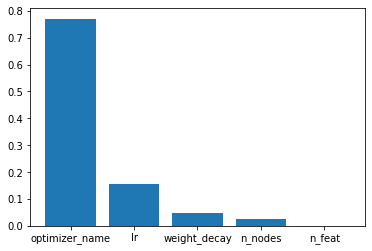

In [ ]:
imp_dict=optuna.importance.get_param_importances(study)
keys=imp_dict.keys()
values=imp_dict.values()
plt.bar(keys, values)
plt.show()

# train best model

In [ ]:
#print(study.best_trial.params)
#param = study.best_trial.params
param={'lr': 0.004295323872283208, 'optimizer_name': 'Adam', 'n_feat': 9, 'weight_decay': 3.9600858968007046e-06, 'n_nodes': 27}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = ConvAutoE(n_feature=param['n_feat'], neur_encoding= param['n_nodes']).to(device)

# Initialization of the optimizer
if param['optimizer_name']=='Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=param['lr'],weight_decay= param['weight_decay'])
elif param['optimizer_name']=='sgd':
    optimizer = optim.SGD(best_model.parameters(), momentum=0.9, lr=param['lr'], weight_decay= param['weight_decay'] )

pp={'num_epochs' : 100,
    'device' : device,
    'patience' : 4}

#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,)             #change train- test dataset
#val_loader = DataLoader(valid_dataset, batch_size=250,shuffle=False)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 3 of 4
INFO: Early stopping counter 4 of 4
INFO: Early stopping


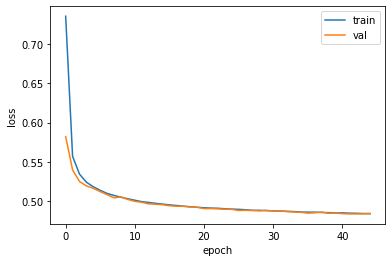

In [ ]:
train_loss, val_loss = best_model.fit(train_dataloader, val_dataloader, optimizer, loss_fn,pp)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
best_model.save("../content/drive/MyDrive/NNDL/Ex2_CAE.pth")

## example of reconstruction

In [ ]:
best_model.load("../content/drive/MyDrive/NNDL/Ex2_CAE.pth")

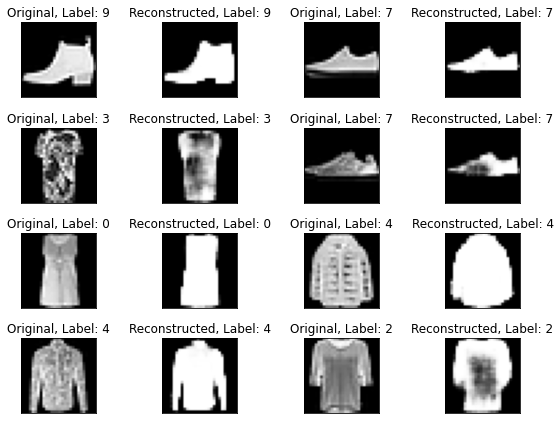

In [ ]:
### Plot some samples from test set
fig, axs = plt.subplots(4, 4, figsize=(8,6))

for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = best_model(img.unsqueeze(0).to(device))
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = best_model(img.unsqueeze(0).to(device))

    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()


# explore the latent space and generate new samples from best_model encoder

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_model.encoder.eval()
    with torch.no_grad():
        encoded_img  = best_model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


  0%|          | 0/10000 [00:00<?, ?it/s]

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,Enc. Variable 16,Enc. Variable 17,Enc. Variable 18,Enc. Variable 19,Enc. Variable 20,Enc. Variable 21,Enc. Variable 22,Enc. Variable 23,Enc. Variable 24,Enc. Variable 25,Enc. Variable 26,label
0,-0.600912,-16.090050,10.714620,-11.741025,-5.600884,3.125843,8.821811,-13.396276,9.679332,4.530361,21.730854,3.768865,-6.721652,1.040053,17.560696,1.884962,-7.001544,6.778878,2.475554,5.866431,6.323084,4.268189,12.394636,6.943744,5.634869,-15.378993,4.917747,9
1,-3.492717,-10.247063,-1.449845,-15.346416,0.143751,24.368717,18.042734,-4.412884,3.439731,-7.914711,-9.784607,8.945883,11.417177,5.465848,-2.306818,-12.337616,11.258796,-12.859617,8.106990,-6.305822,4.212312,4.770031,-6.589857,-4.347008,2.241723,3.501682,3.443117,2
2,4.369016,-20.419453,10.462336,2.186307,2.709751,-8.208011,-11.485041,1.823674,-17.007427,-1.985288,5.784827,-12.406046,-3.200306,-6.627000,19.288879,-12.749578,11.128836,-7.014120,4.217687,-12.139819,-16.483589,7.074440,-14.509429,-1.501542,-6.981000,-24.651123,14.909763,1
3,-6.887355,-15.985868,9.087526,6.765190,2.290049,-1.407726,-17.146748,9.161744,-12.911116,-5.778776,15.032816,-11.290989,-4.305330,-0.978238,11.339746,-6.829951,11.252750,-6.346540,8.548675,-11.476658,3.340799,3.282707,-8.930161,-0.300160,0.265315,-28.577675,7.729884,1
4,7.299441,-2.150556,-5.403252,-6.879675,-0.751789,8.198177,7.274126,-6.970801,-2.900192,-6.533948,3.292907,-2.621168,0.561973,5.409146,-2.374327,-5.833004,-4.413102,-6.817793,4.018936,-3.026773,-2.254136,19.307154,-3.367183,-3.305384,-4.511714,-3.183205,8.338737,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8.062847,-3.692844,-1.841182,-18.183527,0.222364,5.471905,13.869382,-16.740074,14.688041,-3.604685,3.310509,4.088923,-4.502645,3.865829,24.930628,9.435640,5.082632,5.496183,-3.419860,12.052147,5.113751,1.282819,11.180038,6.310326,0.372568,-11.590461,11.071052,9
9996,-6.621275,-18.290981,10.571038,7.446847,0.101100,2.963155,-14.786924,10.721517,-9.340604,-4.466463,18.475533,-12.083864,0.578924,5.159548,11.231526,-4.993506,-2.977714,-2.577043,9.209070,-9.118046,7.694289,7.513982,-3.472826,1.862966,5.245012,-26.832014,2.090951,1
9997,-4.857565,-7.462422,16.696846,-20.081484,-2.006821,15.571386,-14.040442,-12.517905,7.038980,0.908782,12.094269,-13.288709,2.726392,4.303174,0.159346,-3.446738,-3.315372,-10.260922,-10.198699,-13.771605,3.131022,4.967789,-9.949284,8.689791,9.381766,-30.626221,-6.540574,8
9998,5.749490,-18.821627,9.481483,2.814124,4.704231,2.911618,-22.352764,11.687872,-11.814492,1.619482,14.598029,-17.184942,-14.854877,-5.535082,22.056856,0.367959,6.166762,-5.275501,15.587962,-3.369372,-4.652985,0.202073,-7.582950,1.837060,-10.700032,-27.806793,6.840600,1


In [ ]:
from sklearn.decomposition import PCA

pca_encoded          = PCA(n_components = 2)
pca_data             = pca_encoded.fit_transform(encoded_samples.iloc[:,0:-1])
pca_data_df          = pd.DataFrame(data = pca_data, columns = ['var1', 'var2'])
pca_data_df['label'] = encoded_samples.loc[:,'label']
pca_data_df


,var1,var2,label
0,25.268021,21.641941,9
1,-30.968128,13.801779,2
2,7.891224,-36.160301,1
3,16.846296,-35.631302,1
4,-11.329317,4.966332,6
...,...,...,...
9995,6.089235,33.812790,9
9996,24.829317,-29.369045,1
9997,0.393616,-15.373180,8
9998,21.092178,-35.863216,1


In [ ]:
#check for transforming back
X_projected = pca_encoded.inverse_transform(pca_data)
X_projected2 = pca_data.dot(pca_encoded.components_) + pca_encoded.mean_

#look at the graph and select some point in the region more clustered
samples = [[10.6466,-38.5969], [ 31.75419,10.17977], [-28.4299, -19.96884],[46.9303, 1.056598] ]

pca_from_sample=pca_encoded.inverse_transform(samples)
#pca_from_sample

24.65077700391843

In [ ]:
import plotly.express as px


px.scatter(pca_data_df, x='var1', y='var2', color=pca_data_df.label.astype(str), opacity=0.7)



To remember the classes : 
0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"


let's take some point in that space:
1: 10.6466,-38.5969
7 : 31.75419,10.17977
0 : -28.4299, -19.96884
5:46.9303, 1.056598


In [ ]:
import sklearn.manifold as sm
tsne = sm.TSNE(n_components = 2)
tsne.fit(encoded_samples.iloc[:,0:-1])
columns = [ f'Enc. Variable {i}' for i in range(2)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:-1]), columns=columns )
compressed_samples['label'] = encoded_samples.loc[:,'label']

px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=compressed_samples.label.astype(str), opacity=0.7)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# here we use pca to generate new samples
def generate_samples(n_samples, model, n_dim, r = True, samples=None):
    model.decoder.eval()
    
    img_list = []
    if r == True :
        for sample in range(n_samples):
            
            sample_generated = np.random.randint(-30, 30, size =2)
            sample_generated= pca_encoded.inverse_transform(sample_generated)
            #use it as "encoded" data
            encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
            #and now decode it
            # Decode sample
            model.eval()
            with torch.no_grad():
                decoded_generated  = model.decoder(encoded_generated)
            img_list.append(decoded_generated.squeeze().cpu().numpy())    
    
    else: 
        for i in range(n_samples):
            sample_generated = samples[i]
            #use it as "encoded" data
            encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
            #and now decode it
            # Decode sample
            model.eval()
            with torch.no_grad():
                decoded_generated  = model.decoder(encoded_generated)
            img_list.append(decoded_generated.squeeze().cpu().numpy())    

    #same code as above to generate samples
    n_cols = int(n_samples/2)
    
    if n_samples%n_cols == 0:
        n_rows = n_samples//n_cols
    else:
        n_rows = n_samples//n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize = (8, 8))
    for i, img in enumerate(img_list):
        row = i//n_cols
        col = i%n_cols
        ax[row,col].imshow(img, cmap='gist_gray')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Sample "+str(i+1))
    
    plt.tight_layout()
    plt.show()    
        
    return



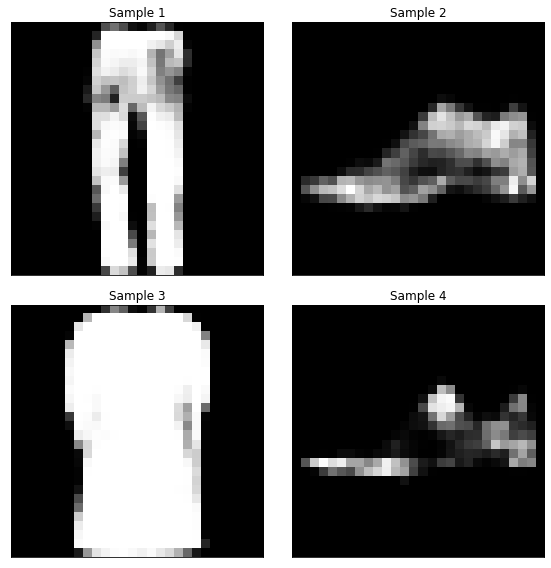

In [ ]:
generate_samples(4, best_model, param['n_nodes'],r=False,samples=pca_from_sample)

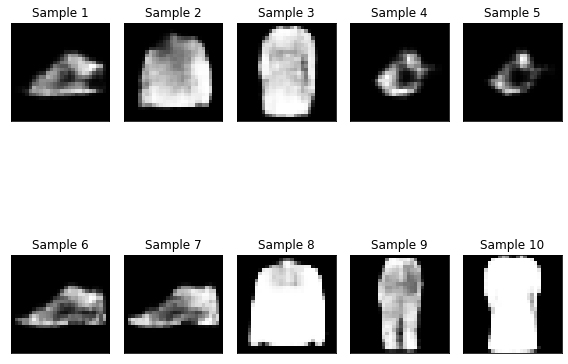

In [ ]:
generate_samples(10, best_model, param['n_nodes'])

# Reconstruction for noisy images

In [ ]:
class AddGaussianNoise():
    '''
    Adds gaussian noise to a tensor
    Inputs:
    mean: default = 0, mean of normal distribution.
    std:  default = 1, standard deviation of normal distribution.
    clip: if True, after adding the noise, restrict values to the [0, 1] range.
    '''
    def __init__(self, mean : float = 0., std : float = 0.2, clip : bool = True):
        
        self.std = std
        self.mean = mean
        self.clip = clip
    
    def __call__(self, tensor : 'torch.tensor'):
        random_part=torch.randn(tensor.size(), device=tensor.device) * (self.std ** 0.5)
        noisy_tensor = tensor + random_part + self.mean
        
        if self.clip:
            return torch.clamp(noisy_tensor, min=0., max=1.)
        else:
            return noisy_tensor
        
class AddSaltPepperNoise(): 
    '''
    Adds "Salt & Pepper" noise to a tensor. 

    amount: probability that an entry of tensor will be affected by the noise. 
    s_vs_p: conditional probability that an entry affected by noise is set to 1 rather than 0.
    clip:   if True, after adding the noise, restrict values to the [0, 1] range.
    '''
    def __init__(self, amount : float = 0.15, s_vs_p : float = 0.5, clip : bool = True):
        
        self.amount = amount
        self.s_vs_p = s_vs_p
        self.clip = clip
    
    def __call__(self, tensor : 'torch.tensor'):
        
        affected_by_noise = torch.rand_like(tensor) < self.amount
        salted = torch.rand_like(tensor) < self.s_vs_p
        peppered = ~salted

        noisy_tensor = torch.clone(tensor)
        noisy_tensor[affected_by_noise & salted] = 1
        noisy_tensor[affected_by_noise & peppered] = 0

        if self.clip:
            return torch.clamp(noisy_tensor, min=0., max=1.)
        else:
            return noisy_tensor
both_noise = torchvision.transforms.Compose([AddSaltPepperNoise(),
                                              AddGaussianNoise(0., 0.2) ])



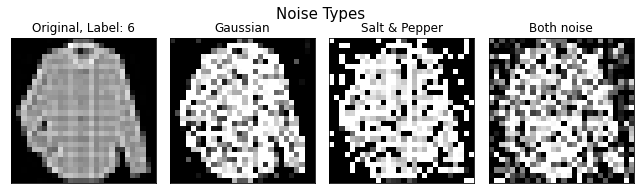

In [ ]:
#working examples

# pick a sample
img, label = random.choice(train_dataset)
#add noise
gaussian = AddGaussianNoise(0,0.2)(img)
spepper = AddSaltPepperNoise(0.3, 0.5)(img)
both=both_noise(img)

#plot

fig, ax = plt.subplots(1, 4, figsize=(9,3))

ax[0].imshow(np.array(img[0]), cmap='gist_gray')
ax[1].imshow(gaussian.squeeze(0).data.numpy(), cmap='gist_gray')
ax[2].imshow(spepper.squeeze(0).data.numpy(), cmap='gist_gray')
ax[3].imshow(both.squeeze(0).data.numpy(), cmap='gist_gray')

ax[0].set_title('Original, Label: %d' % label)
ax[1].set_title('Gaussian')
ax[2].set_title('Salt & Pepper')
ax[3].set_title('Both noise')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xticklabels([])
    a.set_yticklabels([])

fig.suptitle("Noise Types", fontsize=15)
plt.tight_layout()
plt.show()


#### test if the previous VAE work with corrupted images 

it does if the noise is low enough

In [ ]:
best_model.load("../content/drive/MyDrive/NNDL/Ex2_CAE.pth")

In [ ]:

# transform
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])
noise_transform2 = transforms.Compose([
    transforms.ToTensor(),
    AddSaltPepperNoise()
])
noise_transform3 = transforms.Compose([
    transforms.ToTensor(),
    both_noise
])



noise_dataset1  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=noise_transform)
noise_dataset2  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=noise_transform2)
noise_dataset3  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=noise_transform3)

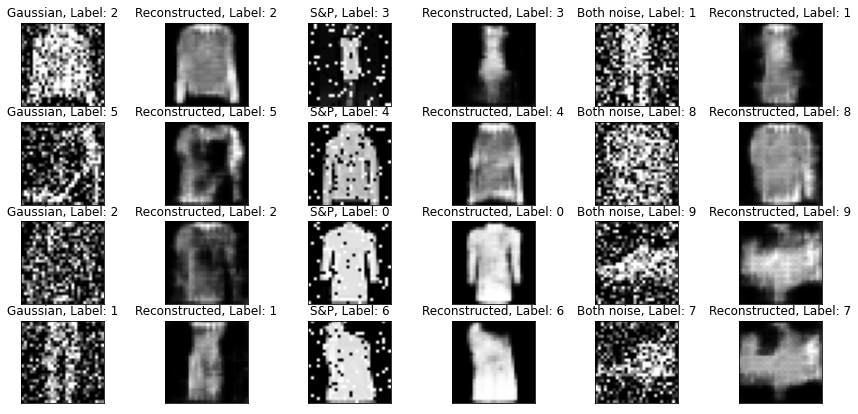

In [ ]:
### Plot some samples from test set
fig, axs = plt.subplots(4, 6, figsize=(15,7))

for ax in axs:
    img, label = random.choice(noise_dataset1)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = best_model(img.unsqueeze(0).to(device))
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Gaussian, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(noise_dataset2)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = best_model(img.unsqueeze(0).to(device))

    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('S&P, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])

    img, label = random.choice(noise_dataset3)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = best_model(img.unsqueeze(0).to(device))

    ax[4].imshow(np.array(img1), cmap='gist_gray')
    ax[4].set_title('Both noise, Label: %d' % label)
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    ax[5].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[5].set_title('Reconstructed, Label: %d' % label)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
    
plt.show()


### retrain with random noise

In [ ]:
class Dataset_noise(torch.utils.data.Dataset):
    
    def __init__(self, dataset : "torch.utils.data.Dataset", noise_transform : "torchvision.transforms"):

        self.dataset = dataset
        self.noise_transform = noise_transform

    def __getitem__(self, index): 
        x, y = self.dataset[index][0], self.dataset[index][1]
        if self.noise_transform == None:
            x_noisy = x
        else:
            x_noisy = self.noise_transform(x)
    
        return x, x_noisy, y

    def __len__(self):
        return len(self.dataset) 


In [ ]:
# datasets
noisy_train = Dataset_noise(noise_transform=both_noise, dataset=train_dataset)
noisy_valid = Dataset_noise(noise_transform=both_noise, dataset=val_dataset)
# the test set does not have noise
noisy_test  = Dataset_noise(noise_transform=None, dataset=test_dataset)

# dataloaders
noisy_train_load = Data.DataLoader(noisy_train, batch_size=256, shuffle=True, num_workers=2)
noisy_valid_load = Data.DataLoader(noisy_valid, batch_size=256, shuffle=False, num_workers=2)
noisy_test_load  = Data.DataLoader(noisy_test, batch_size=256, shuffle=False, num_workers=2)


In [ ]:
class ConvAutoE_noisy(nn.Module):
    def __init__(self,best_model) :
        super().__init__()
        
        # Encoder
        self.model = best_model 


    def forward(self, x):
        x= self.model(x)
        return x

    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        basic training step
        """
        train_loss= []
        self.train() 
        for image_batch ,image_noise, _ in train_loader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            image_noise = image_noise.to(device)
            decoded_data = self.forward(image_noise) # Forward pass
            loss = loss_fn(decoded_data, image_batch) # Compute loss
            
            # Backpropagation
            self.zero_grad() #optimizer.zero_grad()                                   ###########################è uguale ?
            loss.backward()
            
            optimizer.step() # Update the weights
            
            # Save training loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
            # Print batch loss
            #print('\t partial train loss (single batch): %f' % (loss_batch))

        return np.mean(train_loss)


    def validation_step(self, val_loader, loss_fn, device):
        """
        basic validation step
        """
        val_loss = []
        self.eval() 
        with torch.no_grad(): # Disable gradient tracking
            for image_batch , image_noise,  _ in val_loader:
                image_batch = image_batch.to(device)
                image_noise = image_noise.to(device)
                decoded_data = self.forward(image_noise) # Forward pass
                loss = loss_fn(decoded_data, image_batch) # Compute loss
                
                # Save validation loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return np.mean(val_loss)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, params):
        """
        function fit to train the model, it takes the Net, the train and validation 
        loaders, the optimizer and the loss function. 

        params : dictionary of parameters
        """
        early_stopping = EarlyStopping(params['patience'])
        train_loss_log = []
        val_loss_log = []
        for epoch in tqdm(range( params['num_epochs'])): 
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_fn,  params['device'])
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_fn,  params['device'])

            #early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

            # Save average train loss
            train_loss_log.append(train_loss)
            # Save average validation loss
            val_loss_log.append(val_loss)
            #print(f"End_epoch number : {len(val_loss_log)}, train _loss is : {train_loss}, val_loss is {val_loss}" )
            
            #torch.save(self.state_dict(), '../content/drive/MyDrive/NNDL/Ex2_CAE.pth')

            
        return train_loss_log, val_loss_log
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()

In [ ]:
### Define the loss function
loss_fn = nn.MSELoss()

In [ ]:
#print(study.best_trial.params)
#param = study.best_trial.params
param={'lr': 0.004295323872283208, 'optimizer_name': 'Adam', 'n_feat': 9, 'weight_decay': 3.9600858968007046e-06, 'n_nodes': 27}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = ConvAutoE(n_feature=param['n_feat'], neur_encoding= param['n_nodes']).to(device)

# Initialization of the optimizer
if param['optimizer_name']=='Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=param['lr'],weight_decay= param['weight_decay'])
elif param['optimizer_name']=='sgd':
    optimizer = optim.SGD(best_model.parameters(), momentum=0.9, lr=param['lr'], weight_decay= param['weight_decay'] )

pp={'num_epochs' : 100,
    'device' : device,
    'patience' : 4}

denoiser = ConvAutoE_noisy(best_model).to(device)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,)             #change train- test dataset
#val_loader = DataLoader(valid_dataset, batch_size=250,shuffle=False)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 3 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 3 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 1 of 4
INFO: Early stopping counter 2 of 4
INFO: Early stopping counter 3 of 4
INFO: Early stopping counter 4 of 4
INFO: Early stopping


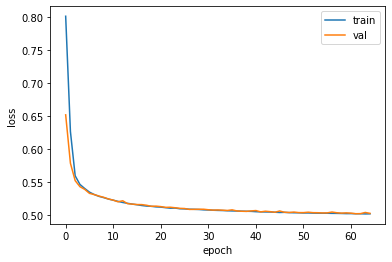

In [ ]:
train_loss, val_loss = denoiser.fit(noisy_train_load, noisy_valid_load, optimizer, loss_fn,pp)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

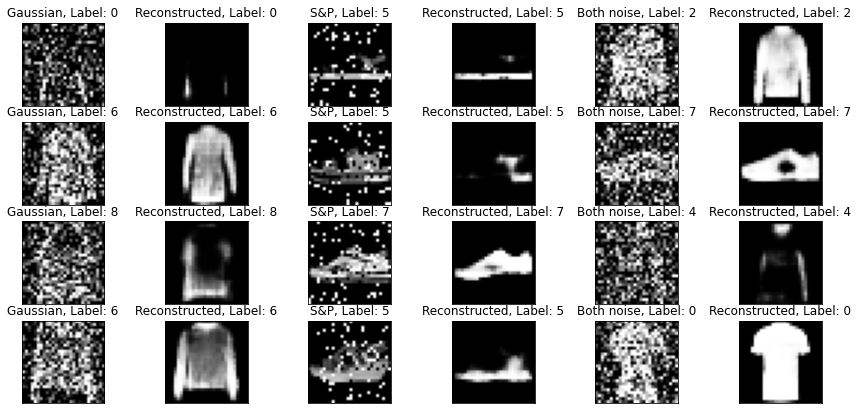

In [ ]:
### Plot some samples from test set
fig, axs = plt.subplots(4, 6, figsize=(15,7))

for ax in axs:
    img, label = random.choice(noise_dataset1)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = denoiser(img.unsqueeze(0).to(device))
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Gaussian, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(noise_dataset2)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = denoiser(img.unsqueeze(0).to(device))

    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('S&P, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])

    img, label = random.choice(noise_dataset3)
    img1 = img[0]
    with torch.no_grad():
        decoded_img  = denoiser(img.unsqueeze(0).to(device))

    ax[4].imshow(np.array(img1), cmap='gist_gray')
    ax[4].set_title('Both noise, Label: %d' % label)
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    ax[5].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[5].set_title('Reconstructed, Label: %d' % label)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
    
plt.show()

In [ ]:
denoiser.save("../content/drive/MyDrive/NNDL/Ex2_CAE_noisy.pth")

## explore the latent space and generate new samples from the denoiser encoder

This part is just to explore the fact that the same encoder trained without noise act better as an image generator (using the pca). 




In [ ]:
denoiser.load("../content/drive/MyDrive/NNDL/Ex2_CAE_noisy.pth")

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    denoiser.model.encoder.eval()
    with torch.no_grad():
        encoded_img  = denoiser.model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


  0%|          | 0/10000 [00:00<?, ?it/s]

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,Enc. Variable 16,Enc. Variable 17,Enc. Variable 18,Enc. Variable 19,Enc. Variable 20,Enc. Variable 21,Enc. Variable 22,Enc. Variable 23,Enc. Variable 24,Enc. Variable 25,Enc. Variable 26,label
0,8.097603,2.761323,-1.956307,-1.856545,-1.636080,-3.872025,-2.594764,10.710013,-21.609026,-1.763177,-3.625581,-0.552945,-11.239197,0.787670,6.770609,-8.824373,8.928804,-0.814140,1.473191,1.160637,-0.887963,-20.613226,-1.471395,2.101524,-10.789010,-1.752608,-0.281175,9
1,-1.318900,14.700558,0.238305,-15.526100,10.498041,29.099039,-14.692533,3.969936,-32.077106,5.315916,2.385092,-15.474946,-8.405749,6.021023,7.225886,15.135515,0.511034,-23.988190,10.446625,12.633533,-1.975401,-35.311478,1.860453,0.154097,4.409506,11.523534,11.097114,2
2,11.802061,4.780016,5.606557,-10.157637,-1.403024,9.483301,1.727316,8.878395,8.721549,2.828059,3.131088,7.696699,3.479115,9.604646,-8.062485,-1.506506,3.054281,-9.164516,3.282948,3.024031,2.354178,12.373169,5.997727,-1.957377,7.221872,-4.091608,4.923409,1
3,11.210135,-2.514819,-0.129801,-3.350942,3.528157,1.415365,-0.407447,-0.296805,6.931229,2.554370,0.933325,5.675420,0.335616,0.508443,-1.159894,-4.015669,1.171908,-11.516537,-0.100558,-4.061768,0.317561,3.586223,1.804538,-1.521311,3.765683,-2.162328,-2.605622,1
4,-5.536129,-3.236262,-3.664986,-0.142213,1.341203,5.835382,0.833303,3.883887,3.932064,5.591975,-9.077589,9.286138,-3.857626,-2.531711,2.398504,2.582147,0.383151,-5.618016,-0.028022,0.798311,-2.474032,-11.206161,0.623241,3.089106,1.224920,1.776121,11.716187,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.584665,-2.478642,5.595669,-12.590588,-3.683517,2.813919,4.119068,11.827393,-29.317259,-4.772726,1.429336,-4.181038,-8.574163,2.378840,8.965338,-1.221595,6.989536,3.892283,0.373496,8.612446,-9.939144,-31.569006,8.361899,-8.193238,-7.287098,-3.898480,14.821890,9
9996,4.280070,-3.150425,1.887414,-2.814886,5.454391,-1.651990,-4.324333,-1.373453,-0.695719,3.183321,1.446515,3.830155,-1.703969,2.069190,-0.654423,-0.885353,2.771168,-7.585595,1.041948,-6.982897,-0.901249,-1.876247,-2.266658,0.591372,-2.485799,-2.925172,-1.489614,1
9997,1.031304,3.275320,-4.288080,-12.434683,3.481320,2.726471,-6.837662,-5.028079,-4.338843,-5.089966,-0.254774,-1.141242,-4.847982,-7.804365,2.509830,-12.025934,-2.348674,-15.649742,-12.722664,0.080108,0.473320,-7.722875,-0.146662,-0.911427,10.303098,-10.620359,5.075975,8
9998,18.386456,-6.875844,9.778197,-7.402501,9.385549,2.605767,4.624402,7.361309,8.639359,1.701556,-1.856962,6.232573,4.651011,-0.635910,-3.535527,-7.280502,-1.804500,-5.440860,0.055041,1.001529,-2.836635,2.018305,6.730186,-3.983408,4.640467,-4.736608,-6.870360,1


In [ ]:
from sklearn.decomposition import PCA

pca_encoded          = PCA(n_components = 2)
pca_data             = pca_encoded.fit_transform(encoded_samples.iloc[:,0:-1])
pca_data_df          = pd.DataFrame(data = pca_data, columns = ['var1', 'var2'])
pca_data_df['label'] = encoded_samples.loc[:,'label']
pca_data_df


,var1,var2,label
0,-19.508053,22.492163,9
1,35.607838,28.825886,2
2,-2.570066,-27.877014,1
3,-13.193174,-22.345087,1
4,-6.310991,-5.935767,6
...,...,...,...
9995,1.879293,36.096733,9
9996,-16.919436,-12.641081,1
9997,-3.434436,-10.224717,8
9998,-13.670769,-22.260668,1


In [ ]:
import plotly.express as px


px.scatter(pca_data_df, x='var1', y='var2', color=pca_data_df.label.astype(str), opacity=0.7)



/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
import sklearn.manifold as sm
tsne = sm.TSNE(n_components = 2)
tsne.fit(encoded_samples.iloc[:,0:-1])
columns = [ f'Enc. Variable {i}' for i in range(2)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:-1]), columns=columns )
compressed_samples['label'] = encoded_samples.loc[:,'label']

px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=compressed_samples.label.astype(str), opacity=0.7)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# here we use pca to generate new samples
def generate_samples(n_samples, model, n_dim, r = True, samples=None):
    model.decoder.eval()
    
    img_list = []
    if r == True :
        for sample in range(n_samples):
            
            sample_generated = np.random.randint(-30, 30, size =2)
            sample_generated= pca_encoded.inverse_transform(sample_generated)
            #use it as "encoded" data
            encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
            #and now decode it
            # Decode sample
            model.eval()
            with torch.no_grad():
                decoded_generated  = model.decoder(encoded_generated)
            img_list.append(decoded_generated.squeeze().cpu().numpy())    
    
    else: 
        for i in range(n_samples):
            sample_generated = samples[i]
            #use it as "encoded" data
            encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
            #and now decode it
            # Decode sample
            model.eval()
            with torch.no_grad():
                decoded_generated  = model.decoder(encoded_generated)
            img_list.append(decoded_generated.squeeze().cpu().numpy())    

    #same code as above to generate samples
    n_cols = int(n_samples/2)
    
    if n_samples%n_cols == 0:
        n_rows = n_samples//n_cols
    else:
        n_rows = n_samples//n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize = (8, 8))
    for i, img in enumerate(img_list):
        row = i//n_cols
        col = i%n_cols
        ax[row,col].imshow(img, cmap='gist_gray')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Sample "+str(i+1))
    
    plt.tight_layout()
    plt.show()    
        
    return



In [ ]:
#check for transforming back
X_projected = pca_encoded.inverse_transform(pca_data)
X_projected2 = pca_data.dot(pca_encoded.components_) + pca_encoded.mean_

#look at the graph and select some point in the region more clustered
samples = [[10.6466,-38.5969], [ 31.75419,10.17977], [-28.4299, -19.96884],[46.9303, 1.056598] ]

pca_from_sample=pca_encoded.inverse_transform(samples)
#pca_from_sample

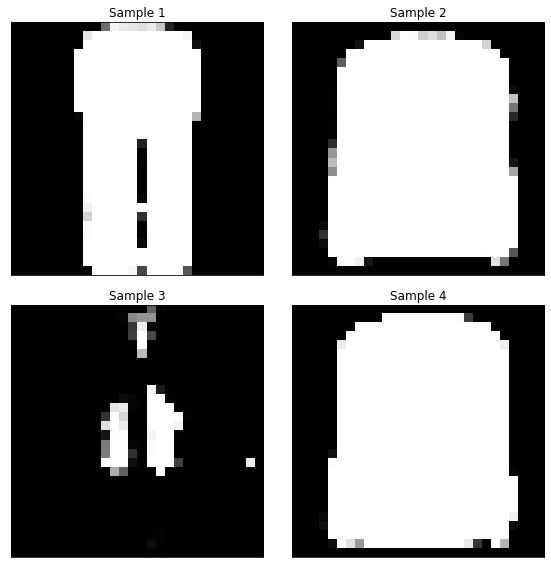

In [ ]:
generate_samples(4, denoiser.model, param['n_nodes'],r=False,samples=pca_from_sample)

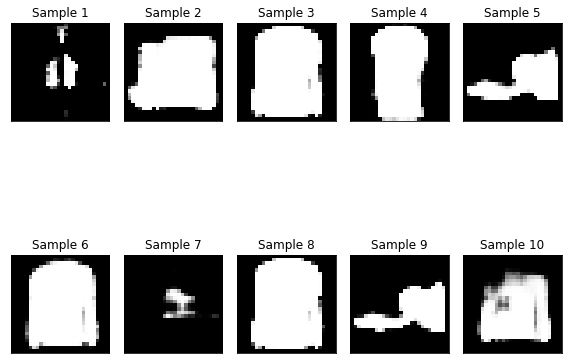

In [ ]:
generate_samples(10, denoiser.model, param['n_nodes'])

# fine-tune the (convolutional) autoencoder
fine-tune the (convolutional) autoencoder using a supervised classification task, and compare classification accuracy and learning speed with results achieved in Homework 1


In [ ]:

class Fine_tune_classificator(nn.Module):

    def __init__(self, previous_encoder, neur_encoding=27, N_h=54, dp=0):

        super().__init__()
        # Encoder
        self.encoder = previous_encoder
        self.fc1 = nn.Linear(neur_encoding, N_h)
        self.fc  = nn.Linear(N_h, 10)
        self.activation = nn.ReLU()
        self.drop= nn.Dropout(p=dp)

    def forward(self, x):
        enc = self.encoder(x)
        x = self.activation(self.fc1(enc))
        x = self.drop(x)
        out = self.fc(x)
        return out

    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        basic training step
        """
        train_loss= []
        self.train() 
        for sample_batched in train_loader:
            x_batch,label_batch= sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device 
            out = self.forward(x_batch) # Forward pass
            loss = loss_fn(out, label_batch) # Compute loss
            
            # Backpropagation
            self.zero_grad()
            loss.backward()
            
            optimizer.step() # Update the weights
            
            # Save training loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        return np.mean(train_loss)

    def validation_step(self, val_loader, loss_fn, device):
        """
        basic validation step
        """
        val_loss = []
        self.eval() 
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_loader:
                x_batch,label_batch = sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device
                out = self.forward(x_batch) # Forward pass
                loss = loss_fn(out, label_batch) # Compute loss
                # Save validation loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return np.mean(val_loss)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, params):
        """
        function fit to train the model, it takes the Net, the train and validation 
        loaders, the optimizer and the loss function. 

        params : dictionary of parameters
        """
        early_stopping = EarlyStopping(params['patience'])
        train_loss_log = []
        val_loss_log = []
        for epoch in range( params['num_epochs']): #tqdm is just for displaying the progress bars
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_fn,  params['device'])
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_fn,  params['device'])

            #early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

            # Save average train loss
            train_loss_log.append(train_loss)
            # Save average validation loss
            val_loss_log.append(val_loss)
            print(f"End_epoch number : {len(val_loss_log)}, train _loss is : {train_loss}, val_loss is {val_loss}" )
            
            #torch.save(self.state_dict(), '../content/drive/MyDrive/NNDL/Ex2_CAE.pth')

            
        return train_loss_log, val_loss_log


    def test(self, test_loader, device, loss_fn):
        """
        function used to get the test_loss and the accuracy
        """
        test_loss = []
        outs=[]
        labs=[]

        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in test_loader:
                x_batch,label_batch= sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device  #[0]
                out = self.forward(x_batch) # Forward pass
                loss = loss_fn(out, label_batch)# Compute the loss
                # Save validation loss and a for this batch
                out = out.cpu().numpy().argmax()
                outs.append(out)
                loss_batch = loss.detach().cpu().numpy()
                labs.append(sample_batched[1].squeeze().tolist())
                test_loss.append( loss_batch.mean() )

        p = np.array([ outs[i]-labs[i] for i in range(len(test_loader.dataset))])
        wrong = len(p[p!=0])/len(test_loader.dataset)

        return np.array(test_loss).mean(), 1.0-wrong
    
    def predict(self, predict_loader, device):
        '''
        Compute an array of predicted labels given input data
        '''
        #set evaluation mode
        self.eval()    
        predictions_list = []

        #disable gradient computing/tracking
        with torch.no_grad():
            for i_batch, sample_batched in enumerate(predict_loader):
                x_batch = sample_batched[0].to(device) 
                #Forward pass
                out = self.forward(x_batch)
                outputs = out.cpu().numpy().argmax()
                predictions_list.append(outputs)

        return np.array( predictions_list )
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()
    



In [ ]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters2(trial):
    # Obtain the learning rate on a logarithmic scale
    lr = trial.suggest_loguniform("lr", 5e-5, 5e-3)

    #Obtain the number of nodes of the second layer
    N_h = trial.suggest_int('n_nodes', 9, 500, step=3)
    
    #obtain the regularization 
    rg = trial.suggest_loguniform("weight_decay",1e-7, 1e-3 )
    
    dp = trial.suggest_float("dp",   0.0, 0.3,step=0.01)

    print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return lr, N_h, rg, dp

In [ ]:
# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs=10

def objective2(trial):
    print("\n********************************\n")
    best_val_loss = float('Inf')
    
    # Start a new mlflow run
    with mlflow.start_run():
        # Get hyperparameter suggestions created by optuna and log them as params using mlflow
        lr, N_h, rg, dp = suggest_hyperparameters2(trial)
        mlflow.log_params(trial.params)

        # Use CUDA if GPU is available and log device as param using mlflow
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        # Initialize network
        model = Fine_tune_classificator(best_model.encoder, N_h=N_h, dp=dp).to(device)

        #freeze the encoder 
        for param in model.encoder.parameters():
            param.requires_grad = False

        # Pick an optimizer based on optuna's parameter suggestion
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=rg)
        
        # Get DataLoaders and validation set
        #train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,)             # change here the train / test set
        #val_loader = DataLoader(valid_dataset, batch_size=1000,shuffle=False)  #


        # Network training & validation loop
        for epoch in range(0, num_epochs):
            model.train()
            avg_train_loss = model.train_step(train_dataloader, optimizer, loss_fn,  device)
            avg_val_loss = model.validation_step(val_dataloader, loss_fn,  device)
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss

            # Log average train and validation set loss metrics for the current epoch using mlflow
            mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
            
            trial.report(avg_val_loss,epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

            print(f"### EPOCH {epoch} val loss is: {avg_val_loss}; train loss is : {avg_train_loss}"  )
            
    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    return best_val_loss   
    
#notice: I report the loss of one epoch for the pruning, but I take the minimum loss reached for the best model params


In [ ]:
from pprint import pformat
# Create the optuna study which shares the experiment name, this will be a random search
#by default optuna use TPE algorithm to perform his search
study2 = optuna.create_study(study_name="pytorch-mlflow-optuna",
                            direction="minimize",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=6 ,n_warmup_steps=2))    
study2.optimize(objective2, n_trials=25)  #    change number of trials



pruned_trials = study2.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study2.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
# Print optuna study statistics
print("\n++++++++++++++++++++++++++++++++++\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study2.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("#########Best trial:###########")
trial = study2.best_trial
print("  Trial number: ", trial.number)
print("  Loss (trial value): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_param = trial.params

[I 2022-02-07 00:06:31,183] A new study created in memory with name: pytorch-mlflow-optuna
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.0,
 'lr': 0.004415229712897688,
 'n_nodes': 246,
 'weight_decay': 0.00023416335987310968}
### EPOCH 0 val loss is: 0.4290935695171356; train loss is : 0.5617529153823853
### EPOCH 1 val loss is: 0.4519498646259308; train loss is : 0.4238605201244354
### EPOCH 2 val loss is: 0.4304301142692566; train loss is : 0.4015580713748932
### EPOCH 3 val loss is: 0.401134192943573; train loss is : 0.3884882926940918
### EPOCH 4 val loss is: 0.3907533884048462; train loss is : 0.3793119192123413
### EPOCH 5 val loss is: 0.4135493338108063; train loss is : 0.36799466609954834
### EPOCH 6 val loss is: 0.3905794620513916; train loss is : 0.3651566207408905
### EPOCH 7 val loss is: 0.38600069284439087; train loss is : 0.35981816053390503
### EPOCH 8 val loss is: 0.3811039924621582; train loss is : 0.3562186360359192


[I 2022-02-07 00:08:31,886] Trial 0 finished with value: 0.3752326965332031 and parameters: {'lr': 0.004415229712897688, 'n_nodes': 246, 'weight_decay': 0.00023416335987310968, 'dp': 0.0}. Best is trial 0 with value: 0.3752326965332031.


### EPOCH 9 val loss is: 0.3752326965332031; train loss is : 0.35062506794929504

********************************

Suggested hyperparameters: 
{'dp': 0.3,
 'lr': 9.106327523389863e-05,
 'n_nodes': 216,
 'weight_decay': 5.097209688383778e-07}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.8919037580490112; train loss is : 2.042743682861328
### EPOCH 1 val loss is: 0.6978510022163391; train loss is : 1.102168321609497
### EPOCH 2 val loss is: 0.6233959197998047; train loss is : 0.8976492285728455
### EPOCH 3 val loss is: 0.5804634690284729; train loss is : 0.7948373556137085
### EPOCH 4 val loss is: 0.5538835525512695; train loss is : 0.7252928018569946
### EPOCH 5 val loss is: 0.5328536629676819; train loss is : 0.6804719567298889
### EPOCH 6 val loss is: 0.5179188251495361; train loss is : 0.6402378678321838
### EPOCH 7 val loss is: 0.5059981346130371; train loss is : 0.617002546787262
### EPOCH 8 val loss is: 0.49465706944465637; train loss is : 0.5910580158233643


[I 2022-02-07 00:10:32,216] Trial 1 finished with value: 0.486412912607193 and parameters: {'lr': 9.106327523389863e-05, 'n_nodes': 216, 'weight_decay': 5.097209688383778e-07, 'dp': 0.3}. Best is trial 0 with value: 0.3752326965332031.


### EPOCH 9 val loss is: 0.486412912607193; train loss is : 0.574895441532135

********************************

Suggested hyperparameters: 
{'dp': 0.04,
 'lr': 0.003933042106767433,
 'n_nodes': 381,
 'weight_decay': 0.00023365941372456526}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.45051705837249756; train loss is : 0.5618669390678406
### EPOCH 1 val loss is: 0.3980771601200104; train loss is : 0.42189350724220276
### EPOCH 2 val loss is: 0.4110202491283417; train loss is : 0.39497870206832886
### EPOCH 3 val loss is: 0.3983485996723175; train loss is : 0.38331446051597595
### EPOCH 4 val loss is: 0.3880159854888916; train loss is : 0.3785225749015808
### EPOCH 5 val loss is: 0.4130794405937195; train loss is : 0.36972469091415405
### EPOCH 6 val loss is: 0.40522846579551697; train loss is : 0.3683004677295685
### EPOCH 7 val loss is: 0.38355404138565063; train loss is : 0.36275917291641235
### EPOCH 8 val loss is: 0.3736439645290375; train loss is : 0.35398268699645996


[I 2022-02-07 00:12:32,597] Trial 2 finished with value: 0.3736439645290375 and parameters: {'lr': 0.003933042106767433, 'n_nodes': 381, 'weight_decay': 0.00023365941372456526, 'dp': 0.04}. Best is trial 2 with value: 0.3736439645290375.


### EPOCH 9 val loss is: 0.37807127833366394; train loss is : 0.35510313510894775

********************************

Suggested hyperparameters: 
{'dp': 0.2,
 'lr': 0.00013705552715356583,
 'n_nodes': 441,
 'weight_decay': 2.088289574408307e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.6252020001411438; train loss is : 1.411323070526123
### EPOCH 1 val loss is: 0.5370456576347351; train loss is : 0.7119463682174683
### EPOCH 2 val loss is: 0.49717551469802856; train loss is : 0.6229052543640137
### EPOCH 3 val loss is: 0.4768264889717102; train loss is : 0.5725102424621582
### EPOCH 4 val loss is: 0.45892369747161865; train loss is : 0.5394123196601868
### EPOCH 5 val loss is: 0.4497717618942261; train loss is : 0.5182498097419739
### EPOCH 6 val loss is: 0.4373120665550232; train loss is : 0.4987331032752991
### EPOCH 7 val loss is: 0.43034934997558594; train loss is : 0.4846437871456146
### EPOCH 8 val loss is: 0.4252975285053253; train loss is : 0.47149643301963806


[I 2022-02-07 00:14:33,061] Trial 3 finished with value: 0.418224573135376 and parameters: {'lr': 0.00013705552715356583, 'n_nodes': 441, 'weight_decay': 2.088289574408307e-05, 'dp': 0.2}. Best is trial 2 with value: 0.3736439645290375.


### EPOCH 9 val loss is: 0.418224573135376; train loss is : 0.4630984365940094

********************************

Suggested hyperparameters: 
{'dp': 0.11,
 'lr': 0.0033489837936132028,
 'n_nodes': 429,
 'weight_decay': 2.8179194279308525e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.444948673248291; train loss is : 0.5908158421516418
### EPOCH 1 val loss is: 0.4021727740764618; train loss is : 0.4323842525482178
### EPOCH 2 val loss is: 0.4036426842212677; train loss is : 0.4110616445541382
### EPOCH 3 val loss is: 0.39186128973960876; train loss is : 0.39497652649879456
### EPOCH 4 val loss is: 0.389374315738678; train loss is : 0.38418683409690857
### EPOCH 5 val loss is: 0.37469619512557983; train loss is : 0.3764423727989197
### EPOCH 6 val loss is: 0.380487322807312; train loss is : 0.3729361295700073
### EPOCH 7 val loss is: 0.40622976422309875; train loss is : 0.366810142993927
### EPOCH 8 val loss is: 0.39287492632865906; train loss is : 0.3627453148365021


[I 2022-02-07 00:16:35,795] Trial 4 finished with value: 0.37469619512557983 and parameters: {'lr': 0.0033489837936132028, 'n_nodes': 429, 'weight_decay': 2.8179194279308525e-05, 'dp': 0.11}. Best is trial 2 with value: 0.3736439645290375.


### EPOCH 9 val loss is: 0.3921840786933899; train loss is : 0.3585183918476105

********************************

Suggested hyperparameters: 
{'dp': 0.18,
 'lr': 8.344475505855654e-05,
 'n_nodes': 141,
 'weight_decay': 2.5210381206649916e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 1.0560290813446045; train loss is : 2.197359800338745
### EPOCH 1 val loss is: 0.7509357333183289; train loss is : 1.087583065032959
### EPOCH 2 val loss is: 0.6532794237136841; train loss is : 0.8660839796066284
### EPOCH 3 val loss is: 0.6027186512947083; train loss is : 0.7660998106002808
### EPOCH 4 val loss is: 0.5708287954330444; train loss is : 0.7043559551239014
### EPOCH 5 val loss is: 0.5489692091941833; train loss is : 0.6666330099105835
### EPOCH 6 val loss is: 0.5312093496322632; train loss is : 0.6316541433334351
### EPOCH 7 val loss is: 0.517387866973877; train loss is : 0.6122523546218872
### EPOCH 8 val loss is: 0.506817102432251; train loss is : 0.5878455638885498


[I 2022-02-07 00:18:37,985] Trial 5 finished with value: 0.4958239495754242 and parameters: {'lr': 8.344475505855654e-05, 'n_nodes': 141, 'weight_decay': 2.5210381206649916e-05, 'dp': 0.18}. Best is trial 2 with value: 0.3736439645290375.


### EPOCH 9 val loss is: 0.4958239495754242; train loss is : 0.5720619559288025

********************************

Suggested hyperparameters: 
{'dp': 0.15,
 'lr': 6.338879150877081e-05,
 'n_nodes': 198,
 'weight_decay': 6.735419241818083e-07}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 1.0395379066467285; train loss is : 2.1156375408172607
### EPOCH 1 val loss is: 0.7510807514190674; train loss is : 1.0668152570724487


[I 2022-02-07 00:19:15,138] Trial 6 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.12,
 'lr': 6.000995677268718e-05,
 'n_nodes': 447,
 'weight_decay': 0.0007267277167071114}
### EPOCH 0 val loss is: 0.8180894255638123; train loss is : 1.908966064453125
### EPOCH 1 val loss is: 0.6488893628120422; train loss is : 0.8345940709114075


[I 2022-02-07 00:19:52,365] Trial 7 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.09,
 'lr': 0.0029065957796420433,
 'n_nodes': 18,
 'weight_decay': 0.0006298960174193331}
### EPOCH 0 val loss is: 0.6043526530265808; train loss is : 0.9848215579986572
### EPOCH 1 val loss is: 0.5411430597305298; train loss is : 0.6274760365486145


[I 2022-02-07 00:20:29,004] Trial 8 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.23,
 'lr': 6.83104879364509e-05,
 'n_nodes': 345,
 'weight_decay': 7.544495430630065e-06}
### EPOCH 0 val loss is: 0.7753872275352478; train loss is : 1.7508714199066162
### EPOCH 1 val loss is: 0.6323692202568054; train loss is : 0.9045954942703247


[I 2022-02-07 00:21:05,878] Trial 9 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.02,
 'lr': 0.001044583463424157,
 'n_nodes': 336,
 'weight_decay': 0.00011902032508957776}
### EPOCH 0 val loss is: 0.4690178334712982; train loss is : 0.6205461025238037
### EPOCH 1 val loss is: 0.4314727485179901; train loss is : 0.4474276006221771
### EPOCH 2 val loss is: 0.4029887616634369; train loss is : 0.4193013310432434
### EPOCH 3 val loss is: 0.39648810029029846; train loss is : 0.39700284600257874
### EPOCH 4 val loss is: 0.3795816898345947; train loss is : 0.3831682503223419
### EPOCH 5 val loss is: 0.3731689751148224; train loss is : 0.3727165758609772
### EPOCH 6 val loss is: 0.37850213050842285; train loss is : 0.36529016494750977
### EPOCH 7 val loss is: 0.3693063259124756; train loss is : 0.35346561670303345
### EPOCH 8 val loss is: 0.36123907566070557; train loss is : 0.3521115779876709


[I 2022-02-07 00:23:07,739] Trial 10 finished with value: 0.360444575548172 and parameters: {'lr': 0.001044583463424157, 'n_nodes': 336, 'weight_decay': 0.00011902032508957776, 'dp': 0.02}. Best is trial 10 with value: 0.360444575548172.


### EPOCH 9 val loss is: 0.360444575548172; train loss is : 0.34567925333976746

********************************

Suggested hyperparameters: 
{'dp': 0.01,
 'lr': 0.0010538384409886164,
 'n_nodes': 315,
 'weight_decay': 0.00011536524524213529}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.4585743248462677; train loss is : 0.6535245776176453
### EPOCH 1 val loss is: 0.431054025888443; train loss is : 0.4459567666053772
### EPOCH 2 val loss is: 0.4107746481895447; train loss is : 0.415552020072937


[I 2022-02-07 00:23:57,038] Trial 11 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.06,
 'lr': 0.00121089632461721,
 'n_nodes': 348,
 'weight_decay': 0.00011081888860718596}
### EPOCH 0 val loss is: 0.4474484920501709; train loss is : 0.5937750339508057
### EPOCH 1 val loss is: 0.41018936038017273; train loss is : 0.4485523998737335
### EPOCH 2 val loss is: 0.39728280901908875; train loss is : 0.4116615653038025
### EPOCH 3 val loss is: 0.38588061928749084; train loss is : 0.39332321286201477
### EPOCH 4 val loss is: 0.3754093050956726; train loss is : 0.38201063871383667
### EPOCH 5 val loss is: 0.37469226121902466; train loss is : 0.37154173851013184
### EPOCH 6 val loss is: 0.37748628854751587; train loss is : 0.3614671230316162
### EPOCH 7 val loss is: 0.37612053751945496; train loss is : 0.35530632734298706
### EPOCH 8 val loss is: 0.3701486885547638; train loss is : 0.34883150458335876


[I 2022-02-07 00:25:59,102] Trial 12 finished with value: 0.36617985367774963 and parameters: {'lr': 0.00121089632461721, 'n_nodes': 348, 'weight_decay': 0.00011081888860718596, 'dp': 0.06}. Best is trial 10 with value: 0.360444575548172.


### EPOCH 9 val loss is: 0.36617985367774963; train loss is : 0.34598788619041443

********************************

Suggested hyperparameters: 
{'dp': 0.06,
 'lr': 0.0007377649532277139,
 'n_nodes': 318,
 'weight_decay': 2.6383816635030064e-06}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.49431735277175903; train loss is : 0.7189865708351135
### EPOCH 1 val loss is: 0.43424126505851746; train loss is : 0.4837726354598999
### EPOCH 2 val loss is: 0.4164009988307953; train loss is : 0.4446178078651428
### EPOCH 3 val loss is: 0.39629387855529785; train loss is : 0.41924619674682617


[I 2022-02-07 00:26:59,115] Trial 13 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.06,
 'lr': 0.0014316554291264303,
 'n_nodes': 495,
 'weight_decay': 7.811834334275717e-05}
### EPOCH 0 val loss is: 0.43779173493385315; train loss is : 0.6141448616981506
### EPOCH 1 val loss is: 0.4278246760368347; train loss is : 0.44482144713401794
### EPOCH 2 val loss is: 0.40156832337379456; train loss is : 0.4132944345474243
### EPOCH 3 val loss is: 0.3778674006462097; train loss is : 0.38715875148773193
### EPOCH 4 val loss is: 0.3717440664768219; train loss is : 0.3716924488544464
### EPOCH 5 val loss is: 0.37030860781669617; train loss is : 0.36199459433555603
### EPOCH 6 val loss is: 0.3657151460647583; train loss is : 0.3541012108325958
### EPOCH 7 val loss is: 0.367826372385025; train loss is : 0.3500916361808777
### EPOCH 8 val loss is: 0.3759022057056427; train loss is : 0.33919522166252136


[I 2022-02-07 00:29:01,437] Trial 14 finished with value: 0.3657151460647583 and parameters: {'lr': 0.0014316554291264303, 'n_nodes': 495, 'weight_decay': 7.811834334275717e-05, 'dp': 0.06}. Best is trial 10 with value: 0.360444575548172.


### EPOCH 9 val loss is: 0.3704077899456024; train loss is : 0.340067058801651

********************************

Suggested hyperparameters: 
{'dp': 0.03,
 'lr': 0.0003032886417098167,
 'n_nodes': 489,
 'weight_decay': 1.0934180536511528e-07}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.5243442058563232; train loss is : 0.786497175693512
### EPOCH 1 val loss is: 0.46747025847435; train loss is : 0.510461688041687


[I 2022-02-07 00:29:37,641] Trial 15 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.08,
 'lr': 0.0019286932338838212,
 'n_nodes': 129,
 'weight_decay': 7.255984004692591e-05}
### EPOCH 0 val loss is: 0.46934205293655396; train loss is : 0.6213422417640686
### EPOCH 1 val loss is: 0.4213464558124542; train loss is : 0.45758160948753357
### EPOCH 2 val loss is: 0.4068900942802429; train loss is : 0.42476776242256165
### EPOCH 3 val loss is: 0.3962748646736145; train loss is : 0.4103190302848816
### EPOCH 4 val loss is: 0.3884621858596802; train loss is : 0.39879605174064636
### EPOCH 5 val loss is: 0.3874756097793579; train loss is : 0.3937114179134369
### EPOCH 6 val loss is: 0.38587701320648193; train loss is : 0.38847431540489197
### EPOCH 7 val loss is: 0.38139137625694275; train loss is : 0.38269108533859253
### EPOCH 8 val loss is: 0.3789612054824829; train loss is : 0.37961968779563904


[I 2022-02-07 00:31:38,588] Trial 16 finished with value: 0.37435758113861084 and parameters: {'lr': 0.0019286932338838212, 'n_nodes': 129, 'weight_decay': 7.255984004692591e-05, 'dp': 0.08}. Best is trial 10 with value: 0.360444575548172.


### EPOCH 9 val loss is: 0.37435758113861084; train loss is : 0.37563613057136536

********************************

Suggested hyperparameters: 
{'dp': 0.0,
 'lr': 0.00037833020706583596,
 'n_nodes': 492,
 'weight_decay': 5.124298454648903e-06}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.5034869909286499; train loss is : 0.7266349196434021
### EPOCH 1 val loss is: 0.45105835795402527; train loss is : 0.4728296101093292


[I 2022-02-07 00:32:14,086] Trial 17 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.14,
 'lr': 0.001908374213075216,
 'n_nodes': 393,
 'weight_decay': 5.199074815600729e-05}
### EPOCH 0 val loss is: 0.4733079969882965; train loss is : 0.6376354098320007
### EPOCH 1 val loss is: 0.41150254011154175; train loss is : 0.4468488395214081
### EPOCH 2 val loss is: 0.39674127101898193; train loss is : 0.4102014899253845
### EPOCH 3 val loss is: 0.3811757564544678; train loss is : 0.39992716908454895
### EPOCH 4 val loss is: 0.37465181946754456; train loss is : 0.38308805227279663
### EPOCH 5 val loss is: 0.38044583797454834; train loss is : 0.3761023283004761
### EPOCH 6 val loss is: 0.3761011064052582; train loss is : 0.36980876326560974
### EPOCH 7 val loss is: 0.3597497045993805; train loss is : 0.36584481596946716
### EPOCH 8 val loss is: 0.37934696674346924; train loss is : 0.3586665093898773


[I 2022-02-07 00:34:14,116] Trial 18 finished with value: 0.3597497045993805 and parameters: {'lr': 0.001908374213075216, 'n_nodes': 393, 'weight_decay': 5.199074815600729e-05, 'dp': 0.14}. Best is trial 18 with value: 0.3597497045993805.


### EPOCH 9 val loss is: 0.36275047063827515; train loss is : 0.3536894917488098

********************************

Suggested hyperparameters: 
{'dp': 0.25,
 'lr': 0.0006148282007722805,
 'n_nodes': 399,
 'weight_decay': 3.912174512155023e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.48279741406440735; train loss is : 0.8123742938041687
### EPOCH 1 val loss is: 0.4360843896865845; train loss is : 0.5286591053009033


[I 2022-02-07 00:34:50,256] Trial 19 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.13,
 'lr': 0.0022155630658063025,
 'n_nodes': 282,
 'weight_decay': 0.0003269725639541541}
### EPOCH 0 val loss is: 0.45390602946281433; train loss is : 0.6196407675743103
### EPOCH 1 val loss is: 0.418060839176178; train loss is : 0.4541321098804474
### EPOCH 2 val loss is: 0.39829710125923157; train loss is : 0.41896161437034607
### EPOCH 3 val loss is: 0.38400062918663025; train loss is : 0.40245306491851807
### EPOCH 4 val loss is: 0.38102248311042786; train loss is : 0.39202073216438293
### EPOCH 5 val loss is: 0.3790455162525177; train loss is : 0.38452595472335815
### EPOCH 6 val loss is: 0.37335294485092163; train loss is : 0.37874096632003784
### EPOCH 7 val loss is: 0.3789817988872528; train loss is : 0.37262094020843506
### EPOCH 8 val loss is: 0.38656607270240784; train loss is : 0.3692692220211029


[I 2022-02-07 00:36:47,632] Trial 20 finished with value: 0.36600786447525024 and parameters: {'lr': 0.0022155630658063025, 'n_nodes': 282, 'weight_decay': 0.0003269725639541541, 'dp': 0.13}. Best is trial 18 with value: 0.3597497045993805.


### EPOCH 9 val loss is: 0.36600786447525024; train loss is : 0.36537259817123413

********************************

Suggested hyperparameters: 
{'dp': 0.15,
 'lr': 0.0015790400543752993,
 'n_nodes': 396,
 'weight_decay': 6.568053250830389e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.43177926540374756; train loss is : 0.6254950761795044
### EPOCH 1 val loss is: 0.40590745210647583; train loss is : 0.44785040616989136
### EPOCH 2 val loss is: 0.3855065405368805; train loss is : 0.41751593351364136
### EPOCH 3 val loss is: 0.3868948221206665; train loss is : 0.39772674441337585
### EPOCH 4 val loss is: 0.38175612688064575; train loss is : 0.38571256399154663
### EPOCH 5 val loss is: 0.37528350949287415; train loss is : 0.3792323172092438
### EPOCH 6 val loss is: 0.3765096962451935; train loss is : 0.3675752282142639
### EPOCH 7 val loss is: 0.35995954275131226; train loss is : 0.3682760000228882
### EPOCH 8 val loss is: 0.3629869222640991; train loss is : 0.35544776916503906


[I 2022-02-07 00:38:46,167] Trial 21 finished with value: 0.35995954275131226 and parameters: {'lr': 0.0015790400543752993, 'n_nodes': 396, 'weight_decay': 6.568053250830389e-05, 'dp': 0.15}. Best is trial 18 with value: 0.3597497045993805.


### EPOCH 9 val loss is: 0.36948511004447937; train loss is : 0.35419338941574097

********************************

Suggested hyperparameters: 
{'dp': 0.17,
 'lr': 0.0008055658767278342,
 'n_nodes': 378,
 'weight_decay': 1.345152375181886e-05}


/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].



### EPOCH 0 val loss is: 0.4725281000137329; train loss is : 0.7539749145507812
### EPOCH 1 val loss is: 0.4355086386203766; train loss is : 0.4975990951061249


[I 2022-02-07 00:39:21,691] Trial 22 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.21,
 'lr': 0.0017845272950595878,
 'n_nodes': 285,
 'weight_decay': 4.990679095224215e-05}
### EPOCH 0 val loss is: 0.4514447748661041; train loss is : 0.6880348920822144
### EPOCH 1 val loss is: 0.4239133894443512; train loss is : 0.46961545944213867


[I 2022-02-07 00:39:57,079] Trial 23 pruned. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [9, 500] and step=3, but the range is not divisible by `step`. It will be replaced by [9, 498].




********************************

Suggested hyperparameters: 
{'dp': 0.16,
 'lr': 0.00039392716596134853,
 'n_nodes': 393,
 'weight_decay': 0.00018854305246117196}
### EPOCH 0 val loss is: 0.5135422348976135; train loss is : 0.8782359957695007
### EPOCH 1 val loss is: 0.4587869942188263; train loss is : 0.5577795505523682


[I 2022-02-07 00:40:32,885] Trial 24 pruned. 



++++++++++++++++++++++++++++++++++

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  12
  Number of complete trials:  13
#########Best trial:###########
  Trial number:  18
  Loss (trial value):  0.3597497045993805
  Params: 
    lr: 0.001908374213075216
    n_nodes: 393
    weight_decay: 5.199074815600729e-05
    dp: 0.14


In [ ]:
optuna.visualization.plot_parallel_coordinate(study2, target_name = 'Validation loss' )

### train best fine tuning

End_epoch number : 1, train _loss is : 0.9128851294517517, val_loss is 0.5029527544975281
End_epoch number : 2, train _loss is : 0.5173956751823425, val_loss is 0.44403865933418274
End_epoch number : 3, train _loss is : 0.46444717049598694, val_loss is 0.4230714738368988
End_epoch number : 4, train _loss is : 0.4370332658290863, val_loss is 0.40508759021759033
End_epoch number : 5, train _loss is : 0.4216393530368805, val_loss is 0.3958189785480499
End_epoch number : 6, train _loss is : 0.40843239426612854, val_loss is 0.38990744948387146
End_epoch number : 7, train _loss is : 0.39765653014183044, val_loss is 0.3898249566555023
End_epoch number : 8, train _loss is : 0.38932546973228455, val_loss is 0.37825897336006165
End_epoch number : 9, train _loss is : 0.38212814927101135, val_loss is 0.375195175409317
End_epoch number : 10, train _loss is : 0.37481364607810974, val_loss is 0.3750563859939575
End_epoch number : 11, train _loss is : 0.36804792284965515, val_loss is 0.369111925363540

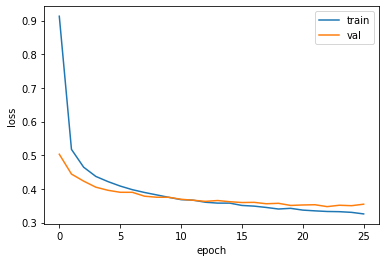

In [ ]:
#best_param={ 'lr': 0.003133194379347082,    
#            'n_nodes': 276,
#            'weight_decay': 1.0141025927008375e-05,
#            'dp': 0.06 }
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_fine_tune = Fine_tune_classificator(best_model.encoder, N_h=best_param['n_nodes'], dp=best_param['dp']).to(device)

# Initialization of the optimizer
optimizer = optim.Adam(best_fine_tune.parameters(), lr=best_param['lr'],weight_decay= best_param['weight_decay'])

pp={'num_epochs' : 100,
    'device' : device,
    'patience' : 4}

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,)             #change train- test dataset
val_loader = DataLoader(val_dataset, batch_size=1000,shuffle=False)

#freeze encoder
for param in best_fine_tune.encoder.parameters():
            param.requires_grad = False

train_loss, val_loss = best_fine_tune.fit(train_loader, val_loader, optimizer, loss_fn,pp)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False)
test_loss , test_acc = best_fine_tune.test(test_loader, device, loss_fn)

print(f"Test loss :{test_loss}, Test Accuracy: {test_acc*100.0}% ")

Test loss :0.37831246852874756, Test Accuracy: 86.41% 


In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

test_loader = DataLoader(test_dataset, batch_size=100,shuffle=False)
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = torch.autograd.Variable(images)
        outputs = best_fine_tune(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 80.80%
Accuracy of Trouser: 96.70%
Accuracy of Pullover: 78.40%
Accuracy of Dress: 86.50%
Accuracy of Coat: 81.40%
Accuracy of Sandal: 95.30%
Accuracy of Shirt: 62.20%
Accuracy of Sneaker: 89.70%
Accuracy of Bag: 96.40%
Accuracy of Ankle Boot: 96.70%


#### confusion matrix

 Frequencies of the classes in the test set:  [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]

 Confusion matrix (normalized)


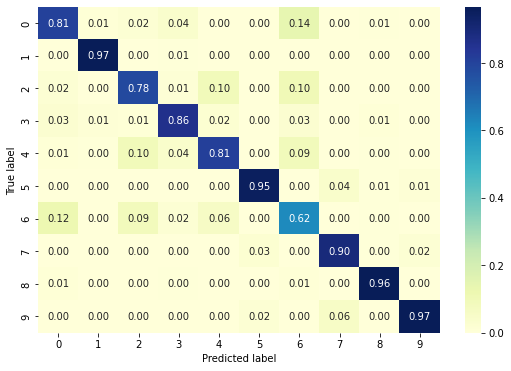

In [ ]:
import seaborn as sns
import sklearn.metrics as metrics

predict_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#Compute the confusion matrix
predictions = best_fine_tune.predict( predict_dataloader, device)
true_labels = np.array([x[1] for x in test_dataset])

#optional plotting parameters
np.set_printoptions(precision=3, suppress=True, floatmode = 'fixed')

_, counts = np.unique(true_labels, return_counts=True)
print(" Frequencies of the classes in the test set: ", counts)

confusion_test = metrics.confusion_matrix( predictions, true_labels)

print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(confusion_test/counts[:,None], annot=True, fmt =  "1.2f" , cmap="YlGnBu" )
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()



#(DC)Gan


In [ ]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 90

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [ ]:
# Data loaders
mean = np.array([0.5])
std = np.array([0.5])
transform = transforms.Compose([transforms.Resize([32, 32]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


data_set = datasets.FashionMNIST('dataset', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True, num_workers=workers)


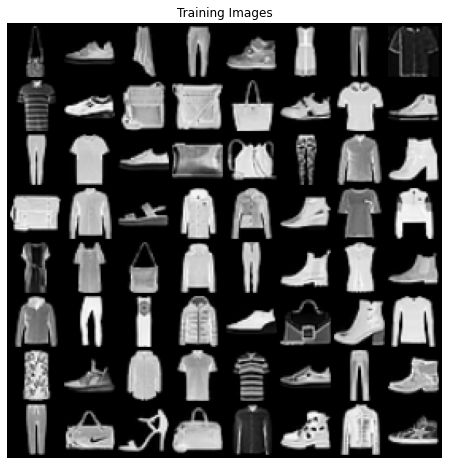

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 6, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 6),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 6, ngf * 3, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 3),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 3, ngf , 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf ),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(90, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 3, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf *3 , ndf * 6, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 6, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/469]	Loss_D: 1.8300	Loss_G: 2.0775	D(x): 0.4104	D(G(z)): 0.4997 / 0.1569
[0/100][50/469]	Loss_D: 0.1599	Loss_G: 6.4235	D(x): 0.8910	D(G(z)): 0.0032 / 0.0067
[0/100][100/469]	Loss_D: 0.4185	Loss_G: 2.1182	D(x): 0.7537	D(G(z)): 0.0818 / 0.1530
[0/100][150/469]	Loss_D: 0.3018	Loss_G: 3.3686	D(x): 0.8940	D(G(z)): 0.1503 / 0.0498
[0/100][200/469]	Loss_D: 0.2023	Loss_G: 3.5990	D(x): 0.8782	D(G(z)): 0.0513 / 0.0392
[0/100][250/469]	Loss_D: 0.3380	Loss_G: 3.4301	D(x): 0.9098	D(G(z)): 0.1856 / 0.0507
[0/100][300/469]	Loss_D: 1.6263	Loss_G: 0.7827	D(x): 0.3236	D(G(z)): 0.0037 / 0.5323
[0/100][350/469]	Loss_D: 1.1807	Loss_G: 4.0859	D(x): 0.9858	D(G(z)): 0.5252 / 0.0418
[0/100][400/469]	Loss_D: 0.2618	Loss_G: 4.0469	D(x): 0.8268	D(G(z)): 0.0295 / 0.0319
[0/100][450/469]	Loss_D: 0.3086	Loss_G: 2.7569	D(x): 0.8700	D(G(z)): 0.1383 / 0.0851
[1/100][0/469]	Loss_D: 0.4049	Loss_G: 1.7741	D(x): 0.7276	D(G(z)): 0.0356 / 0.2105
[1/100][50/469]	Loss_D: 0.4893	Loss_G: 2.257

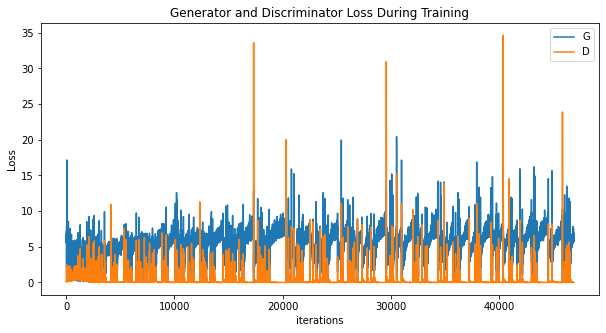

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
'''
This code is not run because it generates a gif of 100 images that, also compressed excedes the 
delivery limit of 10 Mb
'''

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

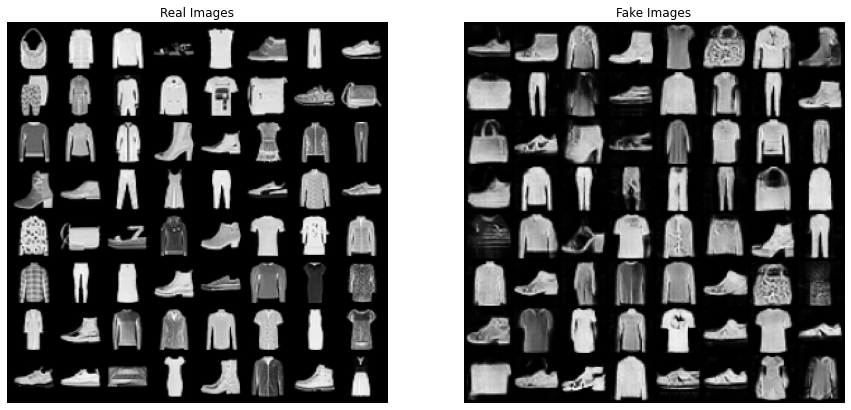

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()